In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
import seaborn as sns
import bootstrapped.bootstrap as bs
import scipy.stats as stats
import bootstrapped.stats_functions as bs_stats
from sklearn import datasets
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, roc_auc_score, auc,f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from itertools import cycle
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

Dataset: 
The dataset contains 7 folders that represent seven types of activities. In
each folder, there are multiple files each of which represents an instant of a human
performing an activity.1 Each file containis 6 time series collected from activities
of the same person, which are called avg rss12, var rss12, avg rss13, var rss13,
vg rss23, and var rss23. There are 88 instances in the dataset, each of which contains
6 time series and each time series has 480 consecutive values.

##### Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [2]:
data_root = '../data/'
activ_dirs = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
filename = 'dataset'
filetype = '.csv'

In [3]:
#walk thrrough directory

all_data = []
train_dataset =[]  # a list of all train datasets
test_dataset =[]   # a list of all test datasets
for label in range(len(activ_dirs)):    
        activ_path = data_root + activ_dirs[label] + '/'
        path, dirs, files = next(os.walk(activ_path))
        file_count = len(files)
        train_data=[]
        test_data=[]
        
        for ins in range(1, file_count+1):
            csv = activ_path + filename + str(ins) + filetype
            df = pd.read_csv(csv, skiprows=4)
            df = df.drop(columns='# Columns: time')
            all_data.append(df)
            #print(df.shape)
            
            if activ_dirs[label] == 'bending1' or activ_dirs[label] == 'bending2':
                
                if ins == 1 or ins == 2:
                    test_data.append(df)
                else:
                    train_data.append(df)
            else:
                if ins == 1 or ins == 2 or ins == 3:
                    test_data.append(df)
                else:
                    train_data.append(df)
                    
        #combine 6 time series (separately) of each train/test dataset file into one dataframe           
        train_data = pd.concat(train_data, ignore_index=True, sort=False)
        test_data = pd.concat(test_data, ignore_index=True, sort=False)
        
        train_data['label'] = activ_dirs[label]
        test_data['label'] = activ_dirs[label]
        train_dataset.append(train_data)
        test_dataset.append(test_data)

In [4]:
#train: dataset3-7 from bending1

train_dataset[0]#.head()

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,label
0,42.00,0.71,21.25,0.43,30.00,0.00,bending1
1,41.50,0.50,20.25,1.48,31.25,1.09,bending1
2,41.50,0.50,14.25,1.92,33.00,0.00,bending1
3,40.75,0.83,15.75,0.43,33.00,0.00,bending1
4,40.00,0.71,20.00,2.74,32.75,0.43,bending1
...,...,...,...,...,...,...,...
2395,44.25,0.83,16.25,1.30,24.00,0.00,bending1
2396,44.00,0.71,11.00,1.00,24.00,0.00,bending1
2397,44.25,0.43,10.25,1.30,22.75,0.83,bending1
2398,43.75,0.43,7.33,2.87,21.50,0.50,bending1


In [5]:
#test: dataset4-15 from walking

test_dataset[6].head()

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,label
0,35.00,3.67,16.50,3.77,14.00,1.63,walking
1,28.50,3.35,17.50,3.77,12.25,3.90,walking
2,35.50,2.87,15.75,2.86,17.75,5.07,walking
3,29.75,12.19,16.25,2.17,20.75,2.59,walking
4,27.00,2.12,16.75,0.83,24.75,1.64,walking


In [6]:
#combine all train datasets from activities folders into one big dataframe
#based on 6 time series separately with labels of each activity

all_train = pd.concat(train_dataset, axis=0, ignore_index=True, sort=False)
all_train

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,label
0,42.00,0.71,21.25,0.43,30.00,0.00,bending1
1,41.50,0.50,20.25,1.48,31.25,1.09,bending1
2,41.50,0.50,14.25,1.92,33.00,0.00,bending1
3,40.75,0.83,15.75,0.43,33.00,0.00,bending1
4,40.00,0.71,20.00,2.74,32.75,0.43,bending1
...,...,...,...,...,...,...,...
33114,34.50,6.18,9.00,3.56,12.67,4.19,walking
33115,25.75,6.02,13.75,2.05,16.00,1.58,walking
33116,31.50,3.35,10.25,5.12,16.25,2.95,walking
33117,33.75,2.77,14.00,3.24,13.75,0.43,walking


In [7]:
#train_x dataframe
alltrain_copy = all_train.copy()
train_x = alltrain_copy.drop(columns=['label'], axis=1)
train_x.head()

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,42.00,0.71,21.25,0.43,30.00,0.00
1,41.50,0.50,20.25,1.48,31.25,1.09
2,41.50,0.50,14.25,1.92,33.00,0.00
3,40.75,0.83,15.75,0.43,33.00,0.00
4,40.00,0.71,20.00,2.74,32.75,0.43


In [8]:
#train_y dataframe
train_y = all_train['label']
train_y.head()

0    bending1
1    bending1
2    bending1
3    bending1
4    bending1
Name: label, dtype: object

In [9]:
#combine all test datasets from activities folders into one big dataframe
#based on 6 time series separately with labels of each activity

all_test = pd.concat(test_dataset, axis=0, ignore_index=True, sort=False)
all_test

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,label
0,39.25,0.43,22.75,0.43,33.75,1.30,bending1
1,39.25,0.43,23.00,0.00,33.00,0.00,bending1
2,39.25,0.43,23.25,0.43,33.00,0.00,bending1
3,39.50,0.50,23.00,0.71,33.00,0.00,bending1
4,39.50,0.50,24.00,0.00,33.00,0.00,bending1
...,...,...,...,...,...,...,...
9115,36.00,2.45,17.00,5.10,20.50,0.87,walking
9116,34.33,1.89,15.00,2.45,17.00,2.12,walking
9117,33.00,7.35,14.60,3.14,13.00,5.70,walking
9118,31.67,1.25,11.00,6.16,19.25,2.17,walking


In [10]:
alltest_copy= all_test.copy()
test_x = alltest_copy.drop(columns=['label'])
test_x.head()

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,39.25,0.43,22.75,0.43,33.75,1.3
1,39.25,0.43,23.00,0.00,33.00,0.0
2,39.25,0.43,23.25,0.43,33.00,0.0
3,39.50,0.50,23.00,0.71,33.00,0.0
4,39.50,0.50,24.00,0.00,33.00,0.0


In [11]:
test_y = all_test['label']
test_y.head()

0    bending1
1    bending1
2    bending1
3    bending1
4    bending1
Name: label, dtype: object

##### Feature Extraction

**Extract the time-domain features minimum, maximum, mean, median, standard
deviation,first quartile, and third quartile for all of the 6 time series
in each instance.**

In [12]:

ins88 = []
train_ins =[]
test_ins =[]
for label in range(len(activ_dirs)):    
        activ_path = data_root + activ_dirs[label] + '/'
        path, dirs, files = next(os.walk(activ_path))
        file_count = len(files)
        
        train_data=[]
        test_data=[]
        tempdata =[]
        for ins in range(1, file_count+1):
            dataset = activ_path + filename + str(ins) + filetype
            df = pd.read_csv(dataset, skiprows=4)
            df = df.drop(columns='# Columns: time')
            #print(df)
            

            features = df.describe().drop('count').transpose()
            #print(features)
            all_instance = pd.concat([features.loc['avg_rss12'], 
                                    features.loc['var_rss12'], 
                                    features.loc['avg_rss13'], 
                                    features.loc['var_rss13'], 
                                    features.loc['avg_rss23'], 
                                    features.loc['var_rss23']], 
                                    axis=0, sort=False)
            
            
            
            all_instance = all_instance.to_frame().transpose()
            all_instance.columns = ['mean1', 'sd1', 'min1', '1st_quar1', 'median1', '3rd_quar1', 'max1',
                                    'mean2', 'sd2', 'min2', '1st_quar2', 'median2', '3rd_quar2', 'max2',
                                    'mean3', 'sd3', 'min3', '1st_quar3', 'median3', '3rd_quar3', 'max3', 
                                    'mean4', 'sd4', 'min4', '1st_quar4', 'median4', '3rd_quar4', 'max4', 
                                    'mean5', 'sd5', 'min5', '1st_quar5', 'median5', '3rd_quar5', 'max5', 
                                    'mean6', 'sd6', 'min6', '1st_quar6', 'median6', '3rd_quar6', 'max6']
                 
#             print(all_instance.shape)
#             print(all_instance)
            
            tempdata.append(all_instance)
        
            if activ_dirs[label] == 'bending1' or activ_dirs[label] == 'bending2':
                if ins == 1 or ins == 2:
                    test_data.append(all_instance)
                else:
                    train_data.append(all_instance)
            else:
                if ins == 1 or ins == 2 or ins == 3:
                    test_data.append(all_instance)
                else:
                    train_data.append(all_instance)
                        
        train_data = pd.concat(train_data, ignore_index=True)
        test_data = pd.concat(test_data, ignore_index=True)
        train_data['label'] = activ_dirs[label]
        test_data['label'] = activ_dirs[label]
        
         #add a column of classes 1 for bending1,2; 0 for others
        if activ_dirs[label] == 'bending1' or activ_dirs[label] == 'bending2':
            train_data['classes'] = 1
            test_data['classes'] = 1
        else:
            train_data['classes'] = 0
            test_data['classes'] = 0
        
        train_ins.append(train_data)
        test_ins.append(test_data)
        
        tempdata = pd.concat(tempdata, ignore_index=True)
        tempdata['label'] = activ_dirs[label]
        ins88.append(tempdata)
        

In [13]:
#concatenate train instances and test instances

train_instance = pd.concat(train_ins, ignore_index=True, sort=False)
test_instance = pd.concat(test_ins, ignore_index=True, sort=False)

In [14]:
train_instance

,mean1,sd1,min1,1st_quar1,median1,3rd_quar1,max1,mean2,sd2,min2,...,max5,mean6,sd6,min6,1st_quar6,median6,3rd_quar6,max6,label,classes
0,43.954500,1.558835,35.00,43.00,44.33,45.0000,47.40,0.426250,0.338690,0.0,...,38.50,0.493292,0.513506,0.00,0.0000,0.43,0.9400,1.79,bending1,1
1,42.179813,3.670666,33.00,39.15,43.50,45.0000,47.75,0.696042,0.630860,0.0,...,38.67,0.613521,0.524317,0.00,0.0000,0.50,1.0000,2.18,bending1,1
2,41.678063,2.243490,33.00,41.33,41.75,42.7500,45.75,0.535979,0.405469,0.0,...,37.50,0.383292,0.389164,0.00,0.0000,0.43,0.5000,1.79,bending1,1
3,43.454958,1.386098,37.00,42.50,43.25,45.0000,48.00,0.378083,0.315566,0.0,...,33.50,0.679646,0.622534,0.00,0.4300,0.50,0.8700,5.26,bending1,1
4,43.969125,1.618364,36.25,43.31,44.50,44.6700,48.00,0.413125,0.263111,0.0,...,30.75,0.555313,0.487826,0.00,0.0000,0.49,0.8300,2.96,bending1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,33.586875,4.650935,19.50,30.25,34.25,37.0000,45.33,4.576562,2.461077,0.0,...,25.00,3.259729,1.640243,0.00,2.0500,3.11,4.3225,8.32,walking,0
65,34.322750,4.752477,19.75,31.00,35.25,38.0000,45.50,4.456333,2.599284,0.0,...,23.25,3.432562,1.732727,0.00,2.1575,3.20,4.5650,9.67,walking,0
66,34.546229,4.842294,19.50,31.25,35.25,37.8125,46.00,4.371958,2.360448,0.0,...,22.75,3.338125,1.656742,0.00,2.1600,3.08,4.3350,10.00,walking,0
67,34.873229,4.531720,23.50,31.75,35.25,38.2500,46.25,4.380583,2.435437,0.0,...,23.50,3.424646,1.690960,0.00,2.1700,3.27,4.5000,9.51,walking,0


In [15]:
test_instance.head()

,mean1,sd1,min1,1st_quar1,median1,3rd_quar1,max1,mean2,sd2,min2,...,max5,mean6,sd6,min6,1st_quar6,median6,3rd_quar6,max6,label,classes
0,40.624792,1.476967,37.25,39.2500,40.50,42.00,45.00,0.358604,0.322605,0.0,...,38.25,0.570583,0.582915,0.0,0.00,0.43,1.30,1.92,bending1,1
1,42.812812,1.435550,38.00,42.0000,42.50,43.67,45.67,0.372438,0.289158,0.0,...,38.50,0.571083,0.601010,0.0,0.00,0.43,1.30,3.11,bending1,1
2,24.562958,3.737514,12.75,23.1875,24.25,26.50,51.00,0.590833,0.837408,0.0,...,30.00,0.700188,0.693720,0.0,0.43,0.50,0.87,4.97,bending2,1
3,27.464604,3.583582,0.00,25.5000,28.00,30.00,42.75,0.449708,0.767197,0.0,...,33.00,1.122125,1.012342,0.0,0.47,0.83,1.30,6.76,bending2,1
4,37.177042,3.581301,24.25,34.5000,36.25,40.25,45.00,2.374208,1.601799,0.0,...,25.50,2.921729,1.852600,0.0,1.50,2.50,3.90,9.34,cycling,0


In [16]:
# #check instance 1 and 2
# ins1 = ins88[0]
# ins2 = ins88[1]
# print(ins1,ins2)

# each file is an instance
#in folder bending1 has 7 files, is 7 instances
#bending 1 has 7 files bending2- 6 files; cycling 15 files; lying 15; sitting 15; standing 15;
#walking 15 
# so totally 7+6+15+15+15+15+15=88 instances 

In [17]:
#merge all instances into one dataframe
#dataframe of 88 instances with their time-domain features for each time series
#and a column of label(activities)

merge_ins = pd.concat(ins88, ignore_index=True)
merge_ins

,mean1,sd1,min1,1st_quar1,median1,3rd_quar1,max1,mean2,sd2,min2,...,3rd_quar5,max5,mean6,sd6,min6,1st_quar6,median6,3rd_quar6,max6,label
0,40.624792,1.476967,37.25,39.25,40.50,42.0000,45.00,0.358604,0.322605,0.0,...,36.00,38.25,0.570583,0.582915,0.00,0.0000,0.43,1.3000,1.92,bending1
1,42.812812,1.435550,38.00,42.00,42.50,43.6700,45.67,0.372438,0.289158,0.0,...,34.50,38.50,0.571083,0.601010,0.00,0.0000,0.43,1.3000,3.11,bending1
2,43.954500,1.558835,35.00,43.00,44.33,45.0000,47.40,0.426250,0.338690,0.0,...,36.50,38.50,0.493292,0.513506,0.00,0.0000,0.43,0.9400,1.79,bending1
3,42.179813,3.670666,33.00,39.15,43.50,45.0000,47.75,0.696042,0.630860,0.0,...,36.33,38.67,0.613521,0.524317,0.00,0.0000,0.50,1.0000,2.18,bending1
4,41.678063,2.243490,33.00,41.33,41.75,42.7500,45.75,0.535979,0.405469,0.0,...,31.25,37.50,0.383292,0.389164,0.00,0.0000,0.43,0.5000,1.79,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,33.586875,4.650935,19.50,30.25,34.25,37.0000,45.33,4.576562,2.461077,0.0,...,18.25,25.00,3.259729,1.640243,0.00,2.0500,3.11,4.3225,8.32,walking
84,34.322750,4.752477,19.75,31.00,35.25,38.0000,45.50,4.456333,2.599284,0.0,...,17.75,23.25,3.432562,1.732727,0.00,2.1575,3.20,4.5650,9.67,walking
85,34.546229,4.842294,19.50,31.25,35.25,37.8125,46.00,4.371958,2.360448,0.0,...,17.75,22.75,3.338125,1.656742,0.00,2.1600,3.08,4.3350,10.00,walking
86,34.873229,4.531720,23.50,31.75,35.25,38.2500,46.25,4.380583,2.435437,0.0,...,18.00,23.50,3.424646,1.690960,0.00,2.1700,3.27,4.5000,9.51,walking


In [18]:
#all instances without label column

all_ins = merge_ins.iloc[:, :42]
all_ins

,mean1,sd1,min1,1st_quar1,median1,3rd_quar1,max1,mean2,sd2,min2,...,median5,3rd_quar5,max5,mean6,sd6,min6,1st_quar6,median6,3rd_quar6,max6
0,40.624792,1.476967,37.25,39.25,40.50,42.0000,45.00,0.358604,0.322605,0.0,...,35.00,36.00,38.25,0.570583,0.582915,0.00,0.0000,0.43,1.3000,1.92
1,42.812812,1.435550,38.00,42.00,42.50,43.6700,45.67,0.372438,0.289158,0.0,...,33.00,34.50,38.50,0.571083,0.601010,0.00,0.0000,0.43,1.3000,3.11
2,43.954500,1.558835,35.00,43.00,44.33,45.0000,47.40,0.426250,0.338690,0.0,...,36.00,36.50,38.50,0.493292,0.513506,0.00,0.0000,0.43,0.9400,1.79
3,42.179813,3.670666,33.00,39.15,43.50,45.0000,47.75,0.696042,0.630860,0.0,...,35.00,36.33,38.67,0.613521,0.524317,0.00,0.0000,0.50,1.0000,2.18
4,41.678063,2.243490,33.00,41.33,41.75,42.7500,45.75,0.535979,0.405469,0.0,...,30.00,31.25,37.50,0.383292,0.389164,0.00,0.0000,0.43,0.5000,1.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,33.586875,4.650935,19.50,30.25,34.25,37.0000,45.33,4.576562,2.461077,0.0,...,16.00,18.25,25.00,3.259729,1.640243,0.00,2.0500,3.11,4.3225,8.32
84,34.322750,4.752477,19.75,31.00,35.25,38.0000,45.50,4.456333,2.599284,0.0,...,15.75,17.75,23.25,3.432562,1.732727,0.00,2.1575,3.20,4.5650,9.67
85,34.546229,4.842294,19.50,31.25,35.25,37.8125,46.00,4.371958,2.360448,0.0,...,15.75,17.75,22.75,3.338125,1.656742,0.00,2.1600,3.08,4.3350,10.00
86,34.873229,4.531720,23.50,31.75,35.25,38.2500,46.25,4.380583,2.435437,0.0,...,16.00,18.00,23.50,3.424646,1.690960,0.00,2.1700,3.27,4.5000,9.51


##### Estimate the standard deviation of each of the time-domain features extracted from the data. Then, use Python's bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [19]:
#calculate stadard deviation for each time-domain feature

std_ins = all_ins.std().to_frame().transpose()
std_ins

,mean1,sd1,min1,1st_quar1,median1,3rd_quar1,max1,mean2,sd2,min2,...,median5,3rd_quar5,max5,mean6,sd6,min6,1st_quar6,median6,3rd_quar6,max6
0,5.335718,1.772153,9.569975,6.15359,5.440054,5.138925,4.394362,1.574164,0.884105,0.0,...,5.813782,5.53172,5.741238,1.154812,0.517617,0.045838,0.758584,1.086474,1.523599,2.518921


In [20]:
cols = all_ins.columns.tolist()
print(cols)

['mean1', 'sd1', 'min1', '1st_quar1', 'median1', '3rd_quar1', 'max1', 'mean2', 'sd2', 'min2', '1st_quar2', 'median2', '3rd_quar2', 'max2', 'mean3', 'sd3', 'min3', '1st_quar3', 'median3', '3rd_quar3', 'max3', 'mean4', 'sd4', 'min4', '1st_quar4', 'median4', '3rd_quar4', 'max4', 'mean5', 'sd5', 'min5', '1st_quar5', 'median5', '3rd_quar5', 'max5', 'mean6', 'sd6', 'min6', '1st_quar6', 'median6', '3rd_quar6', 'max6']


In [21]:
#append each column of std_ins to list

datalis = []
for c in cols:
    val = all_ins[c].values
    datalis.append(val)

#datalis

In [22]:
#iterate each column values to generate bootstrap confidence interval


time_CI=[]
for i in range(len(datalis)):
    data = datalis[i]
    #print(data)
    
    data = (data,)
    res = bootstrap(data, np.std, confidence_level=0.9, method='basic')
    ci = res.confidence_interval
    
    time_CI.append(ci)

In [23]:
len(time_CI)

42

In [24]:
#the list of all 42 confidence interval

time_CI[0]

ConfidenceInterval(low=4.765358353594188, high=5.922000642060548)

In [25]:
sd_lis = std_ins.values.tolist()[0]
#sd_lis

In [26]:
#convert list of CI to dataframe
CI_df = pd.DataFrame(time_CI, index=cols, columns=['CI_low','CI_high'])
CI_df.head()

,CI_low,CI_high
mean1,4.765358,5.922001
sd1,1.584303,1.958772
min1,8.330715,10.810102
1st_quar1,5.632417,6.702674
median1,4.861722,6.048847


In [27]:
CI_df['std_ins'] = sd_lis
CI_df

,CI_low,CI_high,std_ins
mean1,4.765358,5.922001,5.335718
sd1,1.584303,1.958772,1.772153
min1,8.330715,10.810102,9.569975
1st_quar1,5.632417,6.702674,6.153590
median1,4.861722,6.048847,5.440054
3rd_quar1,4.401449,5.924808,5.138925
max1,3.461397,5.406383,4.394362
mean2,1.431525,1.741810,1.574164
sd2,0.821337,0.959286,0.884105
min2,0.000000,0.000000,0.000000


##### select the three most important time-domain features
(one option may be mean, median, and max).

# Time Series Classification: Binary and Multiclass Classification
# (a) Binary Classification Using Logistic Regression


In [28]:
train_instance

,mean1,sd1,min1,1st_quar1,median1,3rd_quar1,max1,mean2,sd2,min2,...,max5,mean6,sd6,min6,1st_quar6,median6,3rd_quar6,max6,label,classes
0,43.954500,1.558835,35.00,43.00,44.33,45.0000,47.40,0.426250,0.338690,0.0,...,38.50,0.493292,0.513506,0.00,0.0000,0.43,0.9400,1.79,bending1,1
1,42.179813,3.670666,33.00,39.15,43.50,45.0000,47.75,0.696042,0.630860,0.0,...,38.67,0.613521,0.524317,0.00,0.0000,0.50,1.0000,2.18,bending1,1
2,41.678063,2.243490,33.00,41.33,41.75,42.7500,45.75,0.535979,0.405469,0.0,...,37.50,0.383292,0.389164,0.00,0.0000,0.43,0.5000,1.79,bending1,1
3,43.454958,1.386098,37.00,42.50,43.25,45.0000,48.00,0.378083,0.315566,0.0,...,33.50,0.679646,0.622534,0.00,0.4300,0.50,0.8700,5.26,bending1,1
4,43.969125,1.618364,36.25,43.31,44.50,44.6700,48.00,0.413125,0.263111,0.0,...,30.75,0.555313,0.487826,0.00,0.0000,0.49,0.8300,2.96,bending1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,33.586875,4.650935,19.50,30.25,34.25,37.0000,45.33,4.576562,2.461077,0.0,...,25.00,3.259729,1.640243,0.00,2.0500,3.11,4.3225,8.32,walking,0
65,34.322750,4.752477,19.75,31.00,35.25,38.0000,45.50,4.456333,2.599284,0.0,...,23.25,3.432562,1.732727,0.00,2.1575,3.20,4.5650,9.67,walking,0
66,34.546229,4.842294,19.50,31.25,35.25,37.8125,46.00,4.371958,2.360448,0.0,...,22.75,3.338125,1.656742,0.00,2.1600,3.08,4.3350,10.00,walking,0
67,34.873229,4.531720,23.50,31.75,35.25,38.2500,46.25,4.380583,2.435437,0.0,...,23.50,3.424646,1.690960,0.00,2.1700,3.27,4.5000,9.51,walking,0


In [29]:
features_select = ['mean1', 'median1', 'max1',
                    'mean2', 'median2', 'max2',
                    'mean6', 'median6', 'max6', 'classes']
train126 = train_instance[features_select]
train126

,mean1,median1,max1,mean2,median2,max2,mean6,median6,max6,classes
0,43.954500,44.33,47.40,0.426250,0.470,1.70,0.493292,0.43,1.79,1
1,42.179813,43.50,47.75,0.696042,0.500,3.00,0.613521,0.50,2.18,1
2,41.678063,41.75,45.75,0.535979,0.500,2.83,0.383292,0.43,1.79,1
3,43.454958,43.25,48.00,0.378083,0.470,1.58,0.679646,0.50,5.26,1
4,43.969125,44.50,48.00,0.413125,0.470,1.50,0.555313,0.49,2.96,1
...,...,...,...,...,...,...,...,...,...,...
64,33.586875,34.25,45.33,4.576562,4.260,14.67,3.259729,3.11,8.32,0
65,34.322750,35.25,45.50,4.456333,3.900,13.47,3.432562,3.20,9.67,0
66,34.546229,35.25,46.00,4.371958,4.135,12.47,3.338125,3.08,10.00,0
67,34.873229,35.25,46.25,4.380583,3.925,14.82,3.424646,3.27,9.51,0


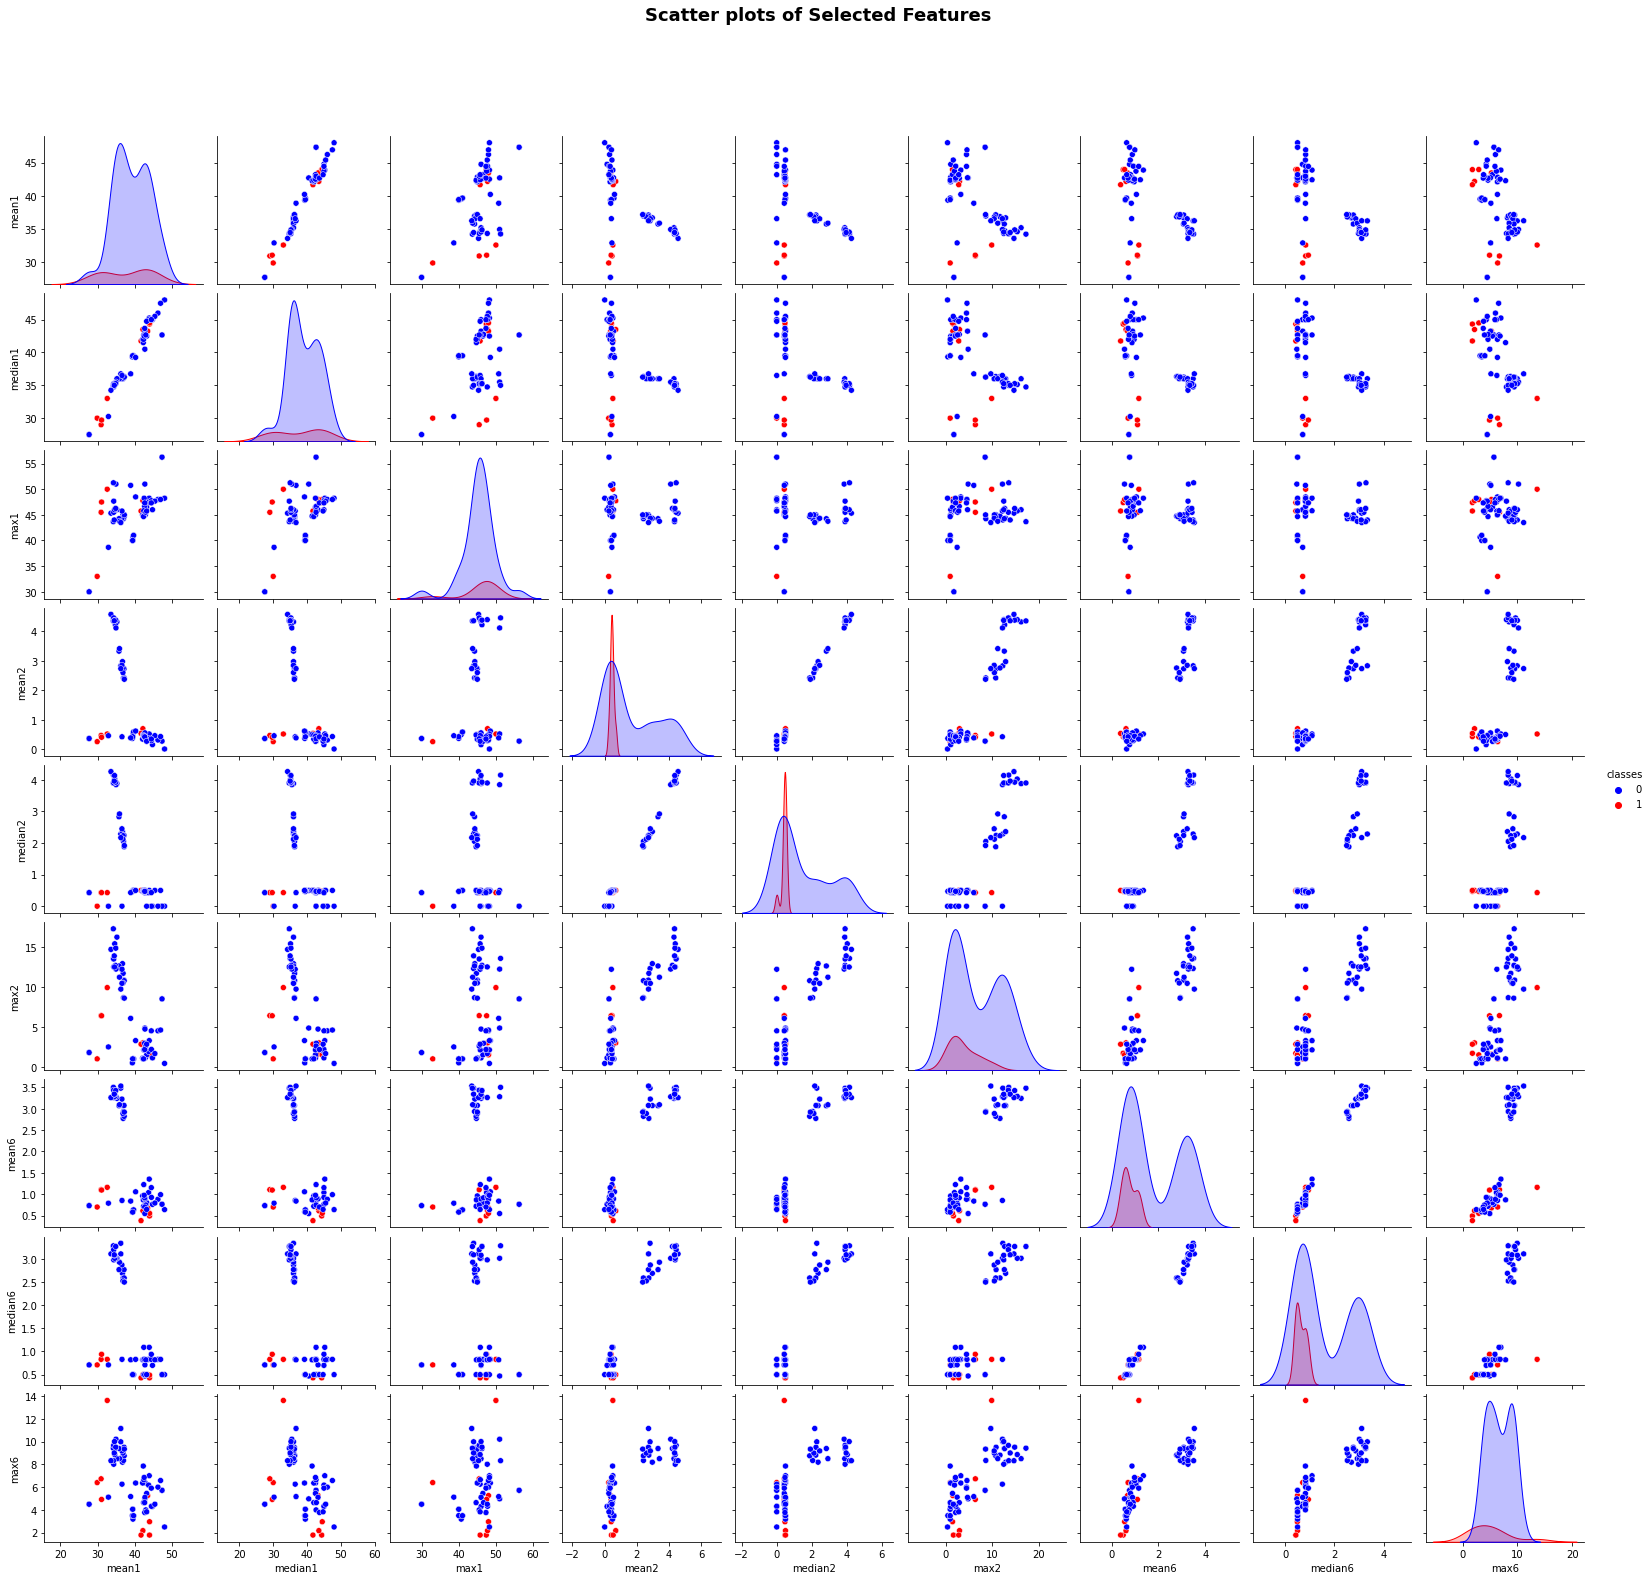

In [30]:
#plot 9x9 pairplot for time-series: 1,2,6, features: mean, median, max

pairplot_fig = sns.pairplot(train126, hue= 'classes', palette={1:'red', 0:'blue'})
plt.subplots_adjust(top=0.9)
pairplot_fig.fig.suptitle("Scatter plots of Selected Features", fontsize=18, alpha=1,weight='bold')
plt.show()

#####  Break each time series in the training set into two (approximately) equal length time series. Repeat the experiment  i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. 

In [31]:
#split rows of each dataset file in every activity folder into half
#6 time series columns become 12 time series columns, 240 rows for each dataframe

train_ins_new=[]
test_ins_new=[]
for label in range(len(activ_dirs)):    
        activ_path = data_root + activ_dirs[label] + '/'
        path, dirs, files = next(os.walk(activ_path))
        file_count = len(files)
        
        train_data=[]
        test_data=[]
        
        for ins in range(1, file_count+1):
            dataset = activ_path + filename + str(ins) + filetype
            df = pd.read_csv(dataset, skiprows=4)
            df = df.drop(columns='# Columns: time')
            #print(len(df))
            
            
            df1 = df[:240]
            df2 = df[240:]
            df2.reset_index(inplace=True, drop=True)
            df3= pd.concat([df1, df2.add_prefix('1')], axis=1)
            #print(df3)
            
            features = df3.describe().drop('count').transpose()
            #print(features)
            
            new_all_instance = pd.concat([features.loc['avg_rss12'], 
                                        features.loc['var_rss12'], 
                                        features.loc['avg_rss13'], 
                                        features.loc['var_rss13'], 
                                        features.loc['avg_rss23'], 
                                        features.loc['var_rss23'],
                                        features.loc['1avg_rss12'], 
                                        features.loc['1var_rss12'], 
                                        features.loc['1avg_rss13'], 
                                        features.loc['1var_rss13'], 
                                        features.loc['1avg_rss23'], 
                                        features.loc['1var_rss23']], 
                                        axis=0, sort=False)
            
            
            
            new_all_instance = new_all_instance.to_frame().transpose()
            new_all_instance.columns = ['mean1', 'sd1', 'min1', '1st_quar1', 'median1', '3rd_quar1', 'max1',
                                    'mean2', 'sd2', 'min2', '1st_quar2', 'median2', '3rd_quar2', 'max2',
                                    'mean3', 'sd3', 'min3', '1st_quar3', 'median3', '3rd_quar3', 'max3', 
                                    'mean4', 'sd4', 'min4', '1st_quar4', 'median4', '3rd_quar4', 'max4', 
                                    'mean5', 'sd5', 'min5', '1st_quar5', 'median5', '3rd_quar5', 'max5', 
                                    'mean6', 'sd6', 'min6', '1st_quar6', 'median6', '3rd_quar6', 'max6',
                                    'mean7', 'sd7', 'min7', '1st_quar7', 'median7', '3rd_quar7', 'max7',
                                    'mean8', 'sd8', 'min8', '1st_quar8', 'median8', '3rd_quar8', 'max8',
                                    'mean9', 'sd9', 'min9', '1st_quar9', 'median9', '3rd_quar9', 'max9', 
                                    'mean10', 'sd10', 'min10', '1st_quar10', 'median10', '3rd_quar10', 'max10', 
                                    'mean11', 'sd11', 'min11', '1st_quar11', 'median11', '3rd_quar11', 'max11', 
                                    'mean12', 'sd12', 'min12', '1st_quar12', 'median12', '3rd_quar12', 'max12']
            
            if activ_dirs[label] == 'bending1' or activ_dirs[label] == 'bending2':
                if ins == 1 or ins == 2:
                    test_data.append(new_all_instance)
                else:
                    train_data.append(new_all_instance)
            else:
                if ins == 1 or ins == 2 or ins == 3:
                    test_data.append(new_all_instance)
                else:
                    train_data.append(new_all_instance)
                        
        train_data = pd.concat(train_data, ignore_index=True)
        test_data = pd.concat(test_data, ignore_index=True)
        train_data['label'] = activ_dirs[label]
        test_data['label'] = activ_dirs[label]
        
         #add a column of classes 1 for bending1,2; 0 for others
        if activ_dirs[label] == 'bending1' or activ_dirs[label] == 'bending2':
            train_data['classes'] = 1
            test_data['classes'] = 1
        else:
            train_data['classes'] = 0
            test_data['classes'] = 0
        
        train_ins_new.append(train_data)
        test_ins_new.append(test_data)
                 

In [32]:
#now have 12 features for every instance
train_ins_new[1]

,mean1,sd1,min1,1st_quar1,median1,3rd_quar1,max1,mean2,sd2,min2,...,max11,mean12,sd12,min12,1st_quar12,median12,3rd_quar12,max12,label,classes
0,32.014375,8.743464,21.0,24.7300,26.125,42.0000,50.00,0.587875,0.936124,0.0,...,24.00,0.786042,0.768408,0.0,0.47,0.71,0.94,6.02,bending2,1
1,30.712417,0.937965,29.0,30.0000,30.290,31.5000,33.00,0.298958,0.299197,0.0,...,21.33,0.677917,0.322210,0.0,0.47,0.71,0.94,1.50,bending2,1
2,29.189875,6.216895,19.0,25.9375,27.000,36.0000,39.25,0.497042,0.731004,0.0,...,36.00,1.114917,0.996452,0.0,0.47,0.87,1.30,5.61,bending2,1
3,34.110625,5.097232,25.0,30.0000,30.500,39.3725,47.50,0.528500,0.712906,0.0,...,18.25,1.199958,0.838177,0.0,0.71,1.00,1.41,4.92,bending2,1


In [33]:
train_instance12 = pd.concat(train_ins_new, ignore_index=True, sort=False)
test_instance12 = pd.concat(test_ins_new, ignore_index=True, sort=False)

In [34]:
train_instance12

,mean1,sd1,min1,1st_quar1,median1,3rd_quar1,max1,mean2,sd2,min2,...,max11,mean12,sd12,min12,1st_quar12,median12,3rd_quar12,max12,label,classes
0,44.057167,1.556971,36.50,43.2500,44.500,45.0000,46.50,0.381042,0.329540,0.0,...,38.25,0.388333,0.478528,0.00,0.0000,0.000,0.7100,1.50,bending1,1
1,43.278875,3.473355,33.75,42.0000,45.000,45.2500,47.75,0.673292,0.634285,0.0,...,38.50,0.586083,0.491873,0.00,0.0000,0.470,0.8700,2.18,bending1,1
2,41.621208,3.118644,33.00,39.6525,42.330,44.2500,45.75,0.623083,0.489595,0.0,...,36.00,0.347500,0.363144,0.00,0.0000,0.430,0.5000,1.50,bending1,1
3,44.117042,1.359836,39.00,43.5000,45.000,45.0000,48.00,0.250042,0.314099,0.0,...,26.00,0.543875,0.473445,0.00,0.4300,0.500,0.7100,4.06,bending1,1
4,43.486208,1.281976,36.67,42.3300,43.710,44.5000,45.00,0.378667,0.284434,0.0,...,26.00,0.585750,0.487918,0.00,0.4225,0.500,0.8300,2.96,bending1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,33.334500,4.874433,19.50,29.9375,34.000,36.8125,45.00,4.408083,2.196206,0.0,...,23.33,3.290292,1.646023,0.43,2.0500,3.155,4.4525,8.32,walking,0
65,34.036750,4.872880,20.33,30.7500,34.415,37.7500,44.50,4.778292,2.762730,0.0,...,23.25,3.321417,1.758379,0.00,2.0500,3.155,4.3950,9.67,walking,0
66,34.033875,4.758757,19.50,30.9375,35.000,37.5000,43.33,4.574625,2.391804,0.0,...,21.33,3.432208,1.691050,0.00,2.1600,3.255,4.5125,8.64,walking,0
67,34.920792,4.272282,24.33,32.2500,35.330,37.8125,44.00,4.177958,2.341763,0.0,...,23.50,3.418667,1.598536,0.00,2.1700,3.350,4.4525,9.51,walking,0


In [35]:
features_select12 = ['mean1', 'median1', 'max1',
                'mean2', 'median2', 'max2',
                'mean6', 'median6', 'max6', 
                'mean7', 'median7', 'max7',
                'mean8', 'median8', 'max8',
                'mean12', 'median12', 'max12','classes']
train12 = train_instance12[features_select12]
train12

,mean1,median1,max1,mean2,median2,max2,mean6,median6,max6,mean7,median7,max7,mean8,median8,max8,mean12,median12,max12,classes
0,44.057167,44.500,46.50,0.381042,0.470,1.50,0.598250,0.500,1.79,43.851833,43.500,47.40,0.471458,0.500,1.70,0.388333,0.000,1.50,1
1,43.278875,45.000,47.75,0.673292,0.485,3.00,0.640958,0.765,1.53,41.080750,42.000,46.00,0.718792,0.500,2.86,0.586083,0.470,2.18,1
2,41.621208,42.330,45.75,0.623083,0.500,2.83,0.419083,0.430,1.79,41.734917,41.500,43.67,0.448875,0.500,1.12,0.347500,0.430,1.50,1
3,44.117042,45.000,48.00,0.250042,0.000,1.30,0.815417,0.710,5.26,42.792875,42.670,46.50,0.506125,0.500,1.58,0.543875,0.500,4.06,1
4,43.486208,43.710,45.00,0.378667,0.470,1.30,0.524875,0.470,2.28,44.452042,44.500,48.00,0.447583,0.500,1.50,0.585750,0.500,2.96,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,33.334500,34.000,45.00,4.408083,4.195,11.78,3.229167,3.110,8.29,33.839250,34.500,45.33,4.745042,4.320,14.67,3.290292,3.155,8.32,0
65,34.036750,34.415,44.50,4.778292,4.030,13.47,3.543708,3.255,8.41,34.608750,35.500,45.50,4.134375,3.740,12.50,3.321417,3.155,9.67,0
66,34.033875,35.000,43.33,4.574625,4.470,12.47,3.244042,2.980,10.00,35.058583,35.875,46.00,4.169292,3.880,12.28,3.432208,3.255,8.64,0
67,34.920792,35.330,44.00,4.177958,3.865,14.82,3.430625,3.270,9.18,34.825667,35.250,46.25,4.583208,4.070,12.26,3.418667,3.350,9.51,0


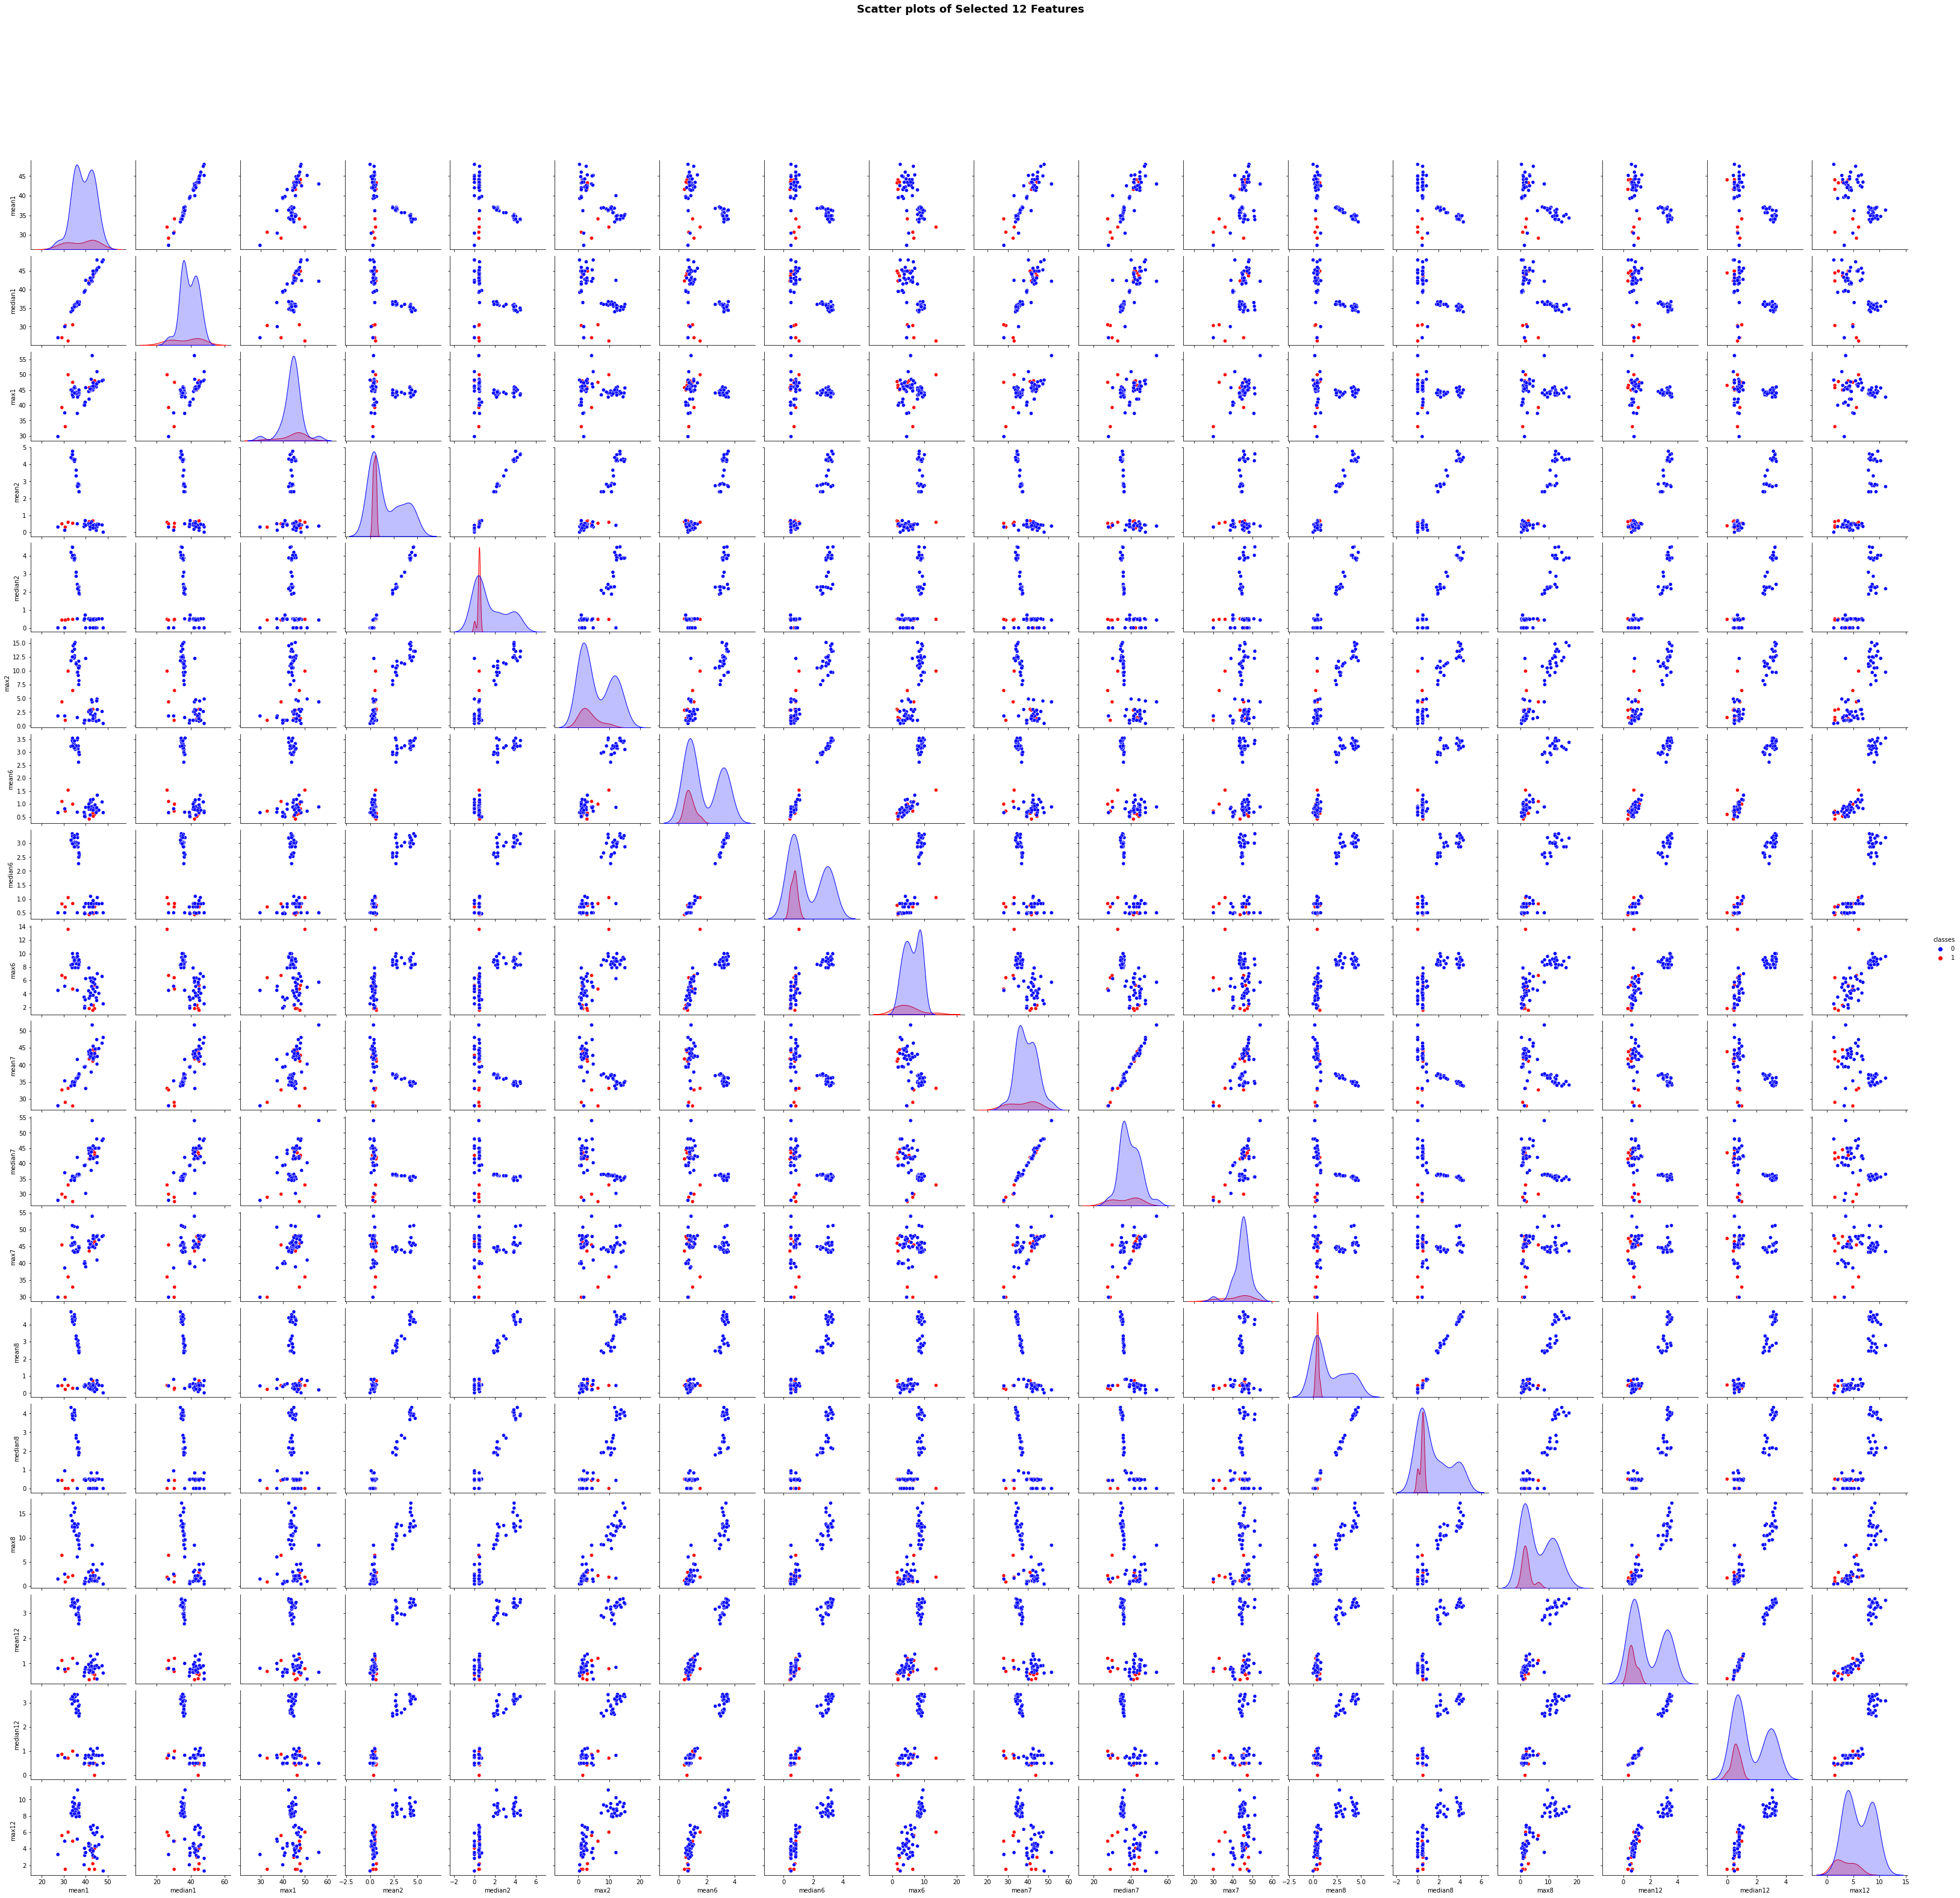

In [36]:
#plot 18x18 pairplot for time-series: 1,2,6,7,8,12 features: mean, median, max

pairplot_fig = sns.pairplot(train12, hue= 'classes', palette={1:'red', 0:'blue'})
plt.subplots_adjust(top=0.9)
pairplot_fig.fig.suptitle("Scatter plots of Selected 12 Features", fontsize=18, alpha=1,weight='bold')
plt.show()

Even though each plot is small, it is easier to see class 1, activity bendings, in red dots. I think it is because the two classes are more separable from each other. 

**Break each time series in the training set into L = (1,20)  time series
of approximately equal length and use logistic regression5 to solve the binary
classification problem, using time-domain features.**

**use backward selection, 5-fold cross-validation to determine the best value of the pair
(l; p), where p is the number of features used in recursive feature elimination.**

In [37]:
L = list(range(1,21))
L

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [38]:

def split_time(df_num):
    train_ins_split=[]
    test_ins_split=[]
    
    for label in range(len(activ_dirs)):    
            activ_path = data_root + activ_dirs[label] + '/'
            path, dirs, files = next(os.walk(activ_path))
            file_count = len(files)

            train_data=[]
            test_data=[]

            for ins in range(1, file_count+1):
                dataset = activ_path + filename + str(ins) + filetype
                df = pd.read_csv(dataset, skiprows=4)
                df = df.drop(columns='# Columns: time')
                #print(len(df))
                
                df1_num = int(len(df)/df_num)
                
                dfs=[]
                dr =[]
                split_num=1
                for i in range(0,df_num):
                    df1 = df[:df1_num]
                    df = df.drop(df.index[:df1_num])
                    dfs.append(df1)
                #print(dfs)
                for d in dfs:
                    d.reset_index(inplace=True, drop=True)
                    #print(d)
                    dr.append(d)
                df_new = pd.concat(dr, axis=1, ignore_index=True)
                #print(df_new)

                features = df_new.describe().drop(['count','std','min','25%','75%']).transpose()
                features = features.rename(columns={"50%": "median"})
                #print(features)

                all_instance_split = pd.concat([features.stack()]).droplevel(0).to_frame().T


                if activ_dirs[label] == 'bending1' or activ_dirs[label] == 'bending2':
                    if ins == 1 or ins == 2:
                        test_data.append(all_instance_split)
                    else:
                        train_data.append(all_instance_split)
                else:
                    if ins == 1 or ins == 2 or ins == 3:
                        test_data.append(all_instance_split)
                    else:
                        train_data.append(all_instance_split)

            train_data = pd.concat(train_data, ignore_index=True)
            test_data = pd.concat(test_data, ignore_index=True)
            train_data['label'] = activ_dirs[label]
            test_data['label'] = activ_dirs[label]

             #add a column of classes 1 for bending1,2; 0 for others
            if activ_dirs[label] == 'bending1' or activ_dirs[label] == 'bending2':
                train_data['classes'] = 1
                test_data['classes'] = 1
            else:
                train_data['classes'] = 0
                test_data['classes'] = 0

            train_ins_split.append(train_data)
            test_ins_split.append(test_data)
    train_instance_any = pd.concat(train_ins_split, ignore_index=True, sort=False)
    test_instance_any = pd.concat(test_ins_split, ignore_index=True, sort=False)
    return train_instance_any,test_instance_any

In [39]:
train_instance_any,test_instance_any = split_time(1)
train_instance_any

,mean,median,max,mean,median,max,mean,median,max,mean,median,max,mean,median,max,mean,median,max,label,classes
0,43.954500,44.33,47.40,0.426250,0.470,1.70,22.122354,23.000,29.75,0.497313,0.43,4.44,35.588458,36.00,38.50,0.493292,0.43,1.79,bending1,1
1,42.179813,43.50,47.75,0.696042,0.500,3.00,22.183625,23.000,30.00,0.989917,0.83,5.15,33.493917,35.00,38.67,0.613521,0.50,2.18,bending1,1
2,41.678063,41.75,45.75,0.535979,0.500,2.83,19.006562,19.125,28.25,0.841875,0.50,6.42,29.857083,30.00,37.50,0.383292,0.43,1.79,bending1,1
3,43.454958,43.25,48.00,0.378083,0.470,1.58,15.793333,15.000,27.00,0.849354,0.50,10.03,23.034792,23.50,33.50,0.679646,0.50,5.26,bending1,1
4,43.969125,44.50,48.00,0.413125,0.470,1.50,15.868021,16.250,26.33,0.666354,0.47,5.17,22.103750,21.67,30.75,0.555313,0.49,2.96,bending1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,33.586875,34.25,45.33,4.576562,4.260,14.67,15.317854,15.330,23.25,3.227229,3.10,9.00,15.892146,16.00,25.00,3.259729,3.11,8.32,walking,0
65,34.322750,35.25,45.50,4.456333,3.900,13.47,15.209771,15.250,22.25,3.277229,3.11,9.00,15.550458,15.75,23.25,3.432562,3.20,9.67,walking,0
66,34.546229,35.25,46.00,4.371958,4.135,12.47,15.185729,15.250,22.67,3.028687,2.86,8.34,15.759542,15.75,22.75,3.338125,3.08,10.00,walking,0
67,34.873229,35.25,46.25,4.380583,3.925,14.82,15.471188,15.500,24.25,3.205688,3.03,9.90,15.873896,16.00,23.50,3.424646,3.27,9.51,walking,0


In [40]:
train_instance_any.shape

(69, 20)

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [42]:
best_features =[] 
num_features=[]
vali_scores=[]
for l in L:
    train_instance_any,test_instance_any = split_time(l)
    
    split_num = 1
    cols=[]
    for c in range(len(train_instance_any.columns)):
        
        col = train_instance_any.columns[c]
        col1 = col +'_'+ str(split_num)
        split_num +=1
        cols.append(col1)
    train_instance_any.columns = cols
    test_instance_any.columns = cols
    #print(cols)
    
    train_X = train_instance_any.iloc[:, :-2]
    train_Y = train_instance_any.iloc[:, -1:]
    train_Y = train_Y.values.ravel()
#     print(train_X)
#     print(train_Y)
    
    
    #apply logistic regression and 5-StratifiedFold CV 
            
    model1 = LogisticRegression(penalty='none', max_iter=100)
    rfecv = RFECV(model1, cv=StratifiedKFold(n_splits=5))
    rfecv = rfecv.fit(train_X, train_Y)


    
    
    #The number of selected features with cross-validation
    num_p = rfecv.n_features_
    num_features.append(num_p)
#     print("L is : ", l)
#     print("number of features: ", num_p)

    

    vali_score = rfecv.grid_scores_
    mean_score = np.mean(vali_score)
    vali_scores.append(mean_score)
    
#     print(l)
#     print(vali_score)
#     print('----')
#     print(mean_score)
    
    mean_mean = np.mean(rfecv.cv_results_['mean_test_score'])
    print(mean_mean)
    #this mean_mean is the same as mean_score
    #use this in the future because .grid_scores will be removed in version 1.2 of RFECV
    
    #select the best features ranking =1
    ranks = rfecv.ranking_
    best_f =[] #columns headers
    for k in range(len(ranks)):
        if ranks[k] == 1:
            best_f.append(train_instance_any.columns[k])
    best_features.append(best_f)

0.9601343101343102
0.9745421245421247
0.9594831094831093
0.9695970695970697
0.9624664224664227
0.9609584859584861
0.9597244025815453
0.9531974969474971
0.9604531271197938
0.9716117216117215
0.9742590742590744
0.9646672771672774
0.9776509814971354
0.9662567591139022
0.9619006919006918
0.9692536630036632
0.972426919485743
0.9781644281644284
0.9635241951031424
0.9698504273504275


In [43]:
print(len(num_features))
print(len(vali_scores))
print(len(best_f))

20
20
44


In [44]:
vali_scores[0]

0.9601343101343102

In [45]:
             
data = {'L':L, 'p':num_features, 'vali_score':vali_scores}
lp_df = pd.DataFrame(data)
lp_df

,L,p,vali_score
0,1,4,0.960134
1,2,6,0.974542
2,3,7,0.959483
3,4,12,0.969597
4,5,13,0.962466
5,6,16,0.960958
6,7,27,0.959724
7,8,25,0.953197
8,9,25,0.960453
9,10,37,0.971612


In [46]:
max_cv = lp_df['vali_score'].max()
print(max_cv)
best_lp = lp_df.loc[lp_df['vali_score']==max_cv, ['L','p']]
best_lp

0.9781644281644282


,L,p
17,18,10


In [47]:
lnum = min(best_lp['L'])
lnum

18

In [48]:
pnum = best_lp.loc[best_lp['L']==lnum, 'p'].iloc[0]
pnum

10

Based on the maximum validation score, the optimal (l,p) is (18,10)

The right way to perform cross-validation is to to perform features selection, logistic regression, inside cross-validation as in the above codes, and use 5-StratifiedFold CV to deal with the problem of class imbalance. Then these selected features are based on k-1 folds. We should not, the wrong way, select the features before performing cross validation. 

In [49]:
#the 10 best features when l=18 p=10
chosen_features = best_features[lnum-1]
chosen_features

['max_15',
 'mean_31',
 'mean_49',
 'median_50',
 'mean_103',
 'median_104',
 'max_183',
 'max_219',
 'max_237',
 'max_297']

**Report the confusion matrix and show the ROC and AUC for the classifier
on train data. Report the parameters of the logistic regression  beta as well
as the p-values associated with them.**

In [50]:
#l = 18 p, number of features =10

#split activities datasets for l=18
train_instance18,test_instance18 = split_time(lnum)
split_num = 1
cols18=[]
for c in range(len(train_instance18.columns)):

    col = train_instance18.columns[c]
    col1 = col +'_'+ str(split_num)
    split_num +=1
    cols18.append(col1)
train_instance18.columns = cols18
test_instance18.columns = cols18


train_X18 = train_instance18.iloc[:, :-2]
train_y18 = train_instance18.iloc[:, -1:]
train_y18 = train_y18.values.ravel()
# print(train_X18)
# print(train_y18)

test_X18 = test_instance18.iloc[:, :-2]
test_y18 = test_instance18.iloc[:, -1:]
test_y18 = test_y18.values.ravel()
# print(test_X18)

In [51]:
#train/test on the 10 best features
#the 10 best features are: chosen_features

model2 = LogisticRegression(penalty='none', max_iter=100)

newtrain_X18 = train_X18[chosen_features]
lrm = model2.fit(newtrain_X18, train_y18)
lrmodel18_score = lrm.score(newtrain_X18, train_y18)
y_predict = lrm.predict(newtrain_X18)
y_score = lrm.decision_function(newtrain_X18)

tn0, fp0, fn0, tp0 = confusion_matrix(train_y18, y_predict).ravel()
print("confusion_matrix: ", tn0, fp0, fn0, tp0)
print('====================================')

fpr0, tpr0, thresholds0 = roc_curve(train_y18, y_score, pos_label=1)
roc_auc0 = auc(fpr0,tpr0)

#print(fpr0,tpr0,thresholds0)
print("lrmodel18 score: ", lrmodel18_score)
print(roc_auc0)

confusion_matrix:  60 0 0 9
lrmodel18 score:  1.0
1.0


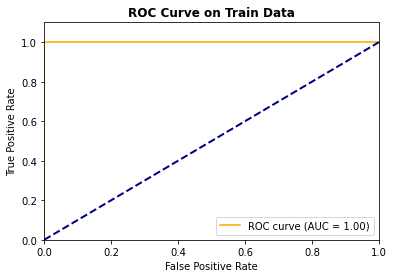

In [52]:
#ROC curve for train data
plt.plot(fpr0, tpr0, color='orange', label="ROC curve (AUC = %0.2f)" % roc_auc0)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.title('ROC Curve on Train Data', weight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [53]:
train_X1 = sm.add_constant(newtrain_X18)
model_logit = sm.Logit(train_y18, train_X1).fit(model='bfgs',maxiter=10)
sum_table = model_logit.summary()
print(sum_table)

         Current function value: 0.000035
         Iterations: 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       58
Method:                           MLE   Df Model:                           10
Date:                Thu, 15 Sep 2022   Pseudo R-squ.:                  0.9999
Time:                        23:27:22   Log-Likelihood:             -0.0024349
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 6.194e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8814    279.512      0.017      0.986    -542.951     552.714
max_15         0.2427     10.286      0.024      0.981     -19.91

The table above shows the 10 coefficients'(betas') values in 'coef' column, and the corresponding p values in column P>|z|. 

**Test the classifier on the test set.**

In [54]:
#test_X18
#test_y18

newtest_X18 = test_X18[chosen_features] 
y_predict_test = lrm.predict(newtest_X18)
test_acc = lrm.score(newtest_X18, test_y18)
y_score_test = lrm.decision_function(newtest_X18)
print("cross-validation accuracy: ", max_cv)
print("lrmodel18 score: ", lrmodel18_score)
print("test accuracy: ", test_acc)

cross-validation accuracy:  0.9781644281644282
lrmodel18 score:  1.0
test accuracy:  0.9473684210526315


In [55]:
#newtest_X18

In [56]:
#get ROC AUC
tnt, fpt, fnt, tpt = confusion_matrix(test_y18, y_predict_test).ravel()
print("confusion_matrix: ", tnt, fpt, fnt, tpt)
print('====================================')

fprt, tprt, thresholdst = roc_curve(test_y18, y_score_test, pos_label=1)
roc_auct = auc(fprt,tprt)
print(roc_auct)

confusion_matrix:  15 0 1 3
1.0


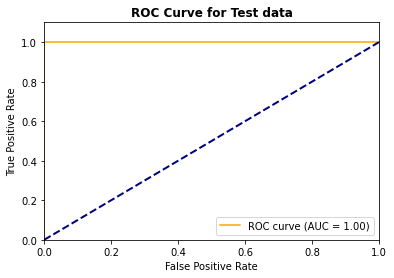

In [57]:
#ROC curve for test data
plt.plot(fprt, tprt, color='orange', label="ROC curve (AUC = %0.2f)" % roc_auct)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.title('ROC Curve for Test data', weight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cross-validation accuracy:  0.9781644281644282\
test accuracy:  0.9473684210526315

    
The CV model accuracy is about 97.8% which builds a nice model over the selected best features. For the same selected  features, the test accuracy is more than 90% which is also close to the CV model accuracy. The model perfoerms well on test data.

According to the confusion matrices, 60 non-bending class, and 9 bending class in train data, yes, the classes, bending/non-bending, are imbalaced. 

In [58]:
#case-control sampling -- undersampling

print("Before undersampling: ", Counter(train_y18))

Before undersampling:  Counter({0: 60, 1: 9})


In [59]:
# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transform using the train and test dataset when l=18
train_X18_under, train_y18_under = undersample.fit_resample(train_X18, train_y18)

# summarize class distribution
print("After undersampling: ", Counter(train_y18_under))

After undersampling:  Counter({0: 9, 1: 9})


In [60]:
#use l=18 p=10 chosen_features

model3 = LogisticRegression(penalty='none', max_iter=100)

newtrain_X18_under = train_X18_under[chosen_features]
lrm = model3.fit(newtrain_X18_under, train_y18_under) 
lrmodel18_score_under = lrm.score(newtrain_X18_under, train_y18_under)
y_predict_under = lrm.predict(newtrain_X18_under)
y_score_under = lrm.decision_function(newtrain_X18_under)

tn1, fp1, fn1, tp1 = confusion_matrix(train_y18_under, y_predict_under).ravel()
print("confusion_matrix: ", tn1, fp1, fn1, tp1)
print('====================================')

fpr1, tpr1, thresholds1 = roc_curve(train_y18_under, y_score_under, pos_label=1)
roc_auc1 = auc(fpr1,tpr1)

#print(fpr1,tpr1,thresholds1)
print("lrmodel18_score_under: ", lrmodel18_score_under)

confusion_matrix:  9 0 0 9
lrmodel18_score_under:  1.0


In [61]:
#newtrain_X18_under

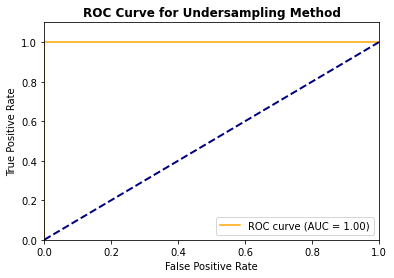

In [62]:
#ROC curve for undersampling data
plt.plot(fpr1, tpr1, color='orange', label="ROC curve (AUC = %0.2f)" % roc_auc1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.title('ROC Curve for Undersampling Method', weight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [63]:
#find out the coefficients, betas' values and the associated P-values
train_X1_under = sm.add_constant(newtrain_X18_under) 
model_logit_under = sm.Logit(train_y18_under, train_X1_under).fit(model='bfgs',maxiter=10)
sum_table_under = model_logit_under.summary()
print(sum_table_under)

         Current function value: 0.000022
         Iterations: 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   18
Model:                          Logit   Df Residuals:                        7
Method:                           MLE   Df Model:                           10
Date:                Thu, 15 Sep 2022   Pseudo R-squ.:                   1.000
Time:                        23:27:22   Log-Likelihood:            -0.00040261
converged:                      False   LL-Null:                       -12.477
Covariance Type:            nonrobust   LLR p-value:                  0.005436
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.6967   3055.844      0.008      0.993   -5963.647    6015.041
max_15        -0.2163     29.011     -0.007      0.994     -57.07

The new coefficients' (betas) values in 'coef' column, and the corresponding p-values in column P>|z| from undersampling method as showing in the table above. 

In [64]:
#test undersampling model on test data
#test_X18 
#test_y18

# fit and apply the transform
test_X18_under, test_y18_under = undersample.fit_resample(test_X18, test_y18)


newtest_X18_under = test_X18_under[chosen_features] 
y_predict_test_under = lrm.predict(newtest_X18_under)
test_acc_under = lrm.score(newtest_X18_under, test_y18_under)
y_score_test_under = lrm.decision_function(newtest_X18_under)
print("cross-validation accuracy: ", max_cv)
print("test accuracy on test undersampling data: ", test_acc_under)

cross-validation accuracy:  0.9781644281644282
test accuracy on test undersampling data:  0.875


In [65]:
#get confusion matrix, ROC AUC
tn2, fp2, fn2, tp2 = confusion_matrix(test_y18_under, y_predict_test_under).ravel()
print("confusion_matrix: ", tn2, fp2, fn2, tp2)
print('====================================')

fpr2, tpr2, thresholds2 = roc_curve(test_y18_under, y_score_test_under, pos_label=1)
roc_auc2 = auc(fpr2,tpr2)


confusion_matrix:  4 0 1 3


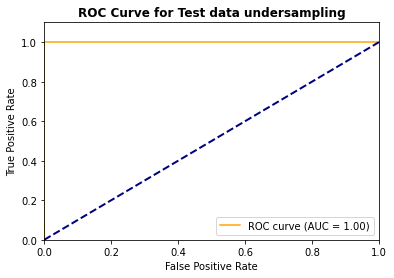

In [66]:
#ROC curve for test data
plt.plot(fpr2, tpr2, color='orange', label="ROC curve (AUC = %0.2f)" % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.title('ROC Curve for Test data undersampling', weight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# (b) Binary Classification Using L1-penalized logistic regression

In [67]:
#split and nomarlize time data

best_C=[]
mean_scores=[]
for l in L:
    train_instance_l1,test_instance_l1 = split_time(l)
    
    split_num = 1
    cols=[]
    for c in range(len(train_instance_l1.columns)):
        
        col = train_instance_l1.columns[c]
        col1 = col +'_'+ str(split_num)
        split_num +=1
        cols.append(col1)
    train_instance_l1.columns = cols
    test_instance_l1.columns = cols
    #print(cols)

    train_Xl1 = train_instance_l1.iloc[:, :-2]
    train_Yl1 = train_instance_l1.iloc[:, -1:]
    train_Yl1 = train_Yl1.values.ravel()
#     print(train_Xl1)
#     print(train_Yl1)
    
    test_Xl1 = test_instance_l1.iloc[:, :-2]
    test_Yl1 = test_instance_l1.iloc[:, -1:]
    test_Yl1 = test_Yl1.values.ravel()
    
    norm = MinMaxScaler()
    train_Xl1_norm = norm.fit_transform(train_Xl1)
    test_Xl1_norm = norm.fit_transform(test_Xl1)
    
    
    #perform logistic regression CV model

    model_L1 = LogisticRegressionCV(penalty='l1',cv=5, solver='liblinear', max_iter=1000, random_state=0)
    lrmcv = model_L1.fit(train_Xl1_norm, train_Yl1)
    

    scoreCs = lrmcv.Cs_
    scoreC = lrmcv.C_
    best_C.append(scoreC)
    
    scores = lrmcv.scores_
    mean_s = np.mean(scores[1])
    mean_scores.append(mean_s)
    
    
#     print(l)
#     print(scoreCs)
#     print(scoreC)
#     print(scores)
#     print(scores[1])



In [68]:
#best_C
#mean_scores

In [69]:

data1 = {'L':L, 'C':best_C, 'model_score':mean_scores}
lC_df = pd.DataFrame(data1)
lC_df['C']= lC_df['C'].astype(float)
lC_df

,L,C,model_score
0,1,2.782559,0.909451
1,2,10000.000000,0.902308
2,3,2.782559,0.912198
3,4,21.544347,0.903516
4,5,2.782559,0.886264
5,6,2.782559,0.896374
6,7,21.544347,0.897692
7,8,2.782559,0.900659
8,9,2.782559,0.892088
9,10,2.782559,0.889121


In [70]:
#finding the best combination of L and C 

max_score = lC_df['model_score'].max()
print(max_score)
best_lC = lC_df.loc[lC_df['model_score']==max_score, ['L','C']]
best_lC

0.9121978021978022


,L,C
2,3,2.782559


In [71]:
#print out the best l,C values for L1 model
binary_l = min(best_lC['L'])
binary_C = best_lC.loc[best_lC['L']==binary_l, 'C'].iloc[0]
print(binary_l)
print(binary_C)

3
2.782559402207126


In [72]:
#lambda if needed
#Tuning Parameter lambda
#C=1/lambda
lambda_l1 = 1/binary_C
lambda_l1

0.3593813663804626

In [73]:
#use the best (l,C)

#split activities datasets for the best L
train_instance3,test_instance3 = split_time(binary_l)
split_num = 1
cols3=[]
for c in range(len(train_instance3.columns)):

    col = train_instance3.columns[c]
    col1 = col +'_'+ str(split_num)
    split_num +=1
    cols3.append(col1)
train_instance3.columns = cols3
test_instance3.columns = cols3


train_X3 = train_instance3.iloc[:, :-2]
train_y3 = train_instance3.iloc[:, -1:]
train_y3 = train_y3.values.ravel()
# print(train_X3)
# print(train_y3)

test_X3 = test_instance3.iloc[:, :-2]
test_y3 = test_instance3.iloc[:, -1:]
test_y3 = test_y3.values.ravel()
# print(test_X3)
# print(test_y3)

#normalized datasets
norm3 = MinMaxScaler()
train_X_norm3 = norm3.fit_transform(train_X3)
test_X_norm3 = norm3.fit_transform(test_X3)

In [74]:
#get/fit the best l and C into logit model
L1model = LogisticRegression(solver='liblinear', penalty='l1', C=binary_C)
L1lrm = L1model.fit(train_X_norm3, train_y3)


#model score on train set
L1model_score = L1lrm.score(train_X_norm3, train_y3)


L1_y_predict = L1lrm.predict(train_X_norm3)
tnl1, fpl1, fnl1, tpl1 = confusion_matrix(train_y3, L1_y_predict).ravel()
print("confusion_matrix: ", tnl1, fpl1, fnl1, tpl1)

L1_y_score = L1lrm.decision_function(train_X_norm3)
fprl1, tprl1, thresholdsl1 = roc_curve(train_y3, L1_y_score, pos_label=1)
roc_aucl1 = auc(fprl1,tprl1)

confusion_matrix:  60 0 0 9


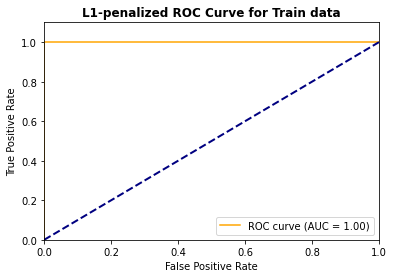

In [75]:
#ROC curve for L1 train data
plt.plot(fprl1, tprl1, color='orange', label="ROC curve (AUC = %0.2f)" % roc_aucl1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.title('L1-penalized ROC Curve for Train data', weight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [76]:
#test L1 model on test set
L1_y_predict_test = L1lrm.predict(test_X_norm3)
L1test_acc = L1lrm.score(test_X_norm3, test_y3)
L1_y_score_test = L1lrm.decision_function(test_X_norm3)
print("cross-validation accuracy: ", max_score)
print("test accuracy: ", L1test_acc)
print("model accuracy: ", L1model_score)

tnl1t, fpl1t, fnl1t, tpl1t = confusion_matrix(test_y3, L1_y_predict_test).ravel()
print("confusion_matrix: ", tnl1t, fpl1t, fnl1t, tpl1t)


#get ROC AUC
fprl1t, tprl1t, thresholdsl1t = roc_curve(test_y3, L1_y_score_test, pos_label=1)
L1roc_auc = auc(fprl1t,tprl1t)


cross-validation accuracy:  0.9121978021978022
test accuracy:  0.9473684210526315
model accuracy:  1.0
confusion_matrix:  15 0 1 3


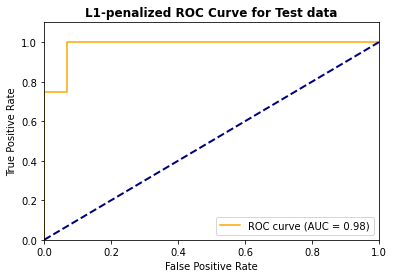

In [77]:
#ROC curve for L1 test data
plt.plot(fprl1t, tprl1t, color='orange', label="ROC curve (AUC = %0.2f)" % L1roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.title('L1-penalized ROC Curve for Test data', weight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

**Compare the L1-penalized with variable selection using p-values. Which one
performs better? Which one is easier to implement?**

In [78]:
#L1 model l=3 C= 2.782559402207126
print("cross-validation accuracy: ", max_score)
print("model accuracy: ", L1model_score)
print("confusion_matrix: ", tnl1, fpl1, fnl1, tpl1)
print("test accuracy: ", L1test_acc)
print("confusion_matrix: ", tnl1t, fpl1t, fnl1t, tpl1t)


cross-validation accuracy:  0.9121978021978022
model accuracy:  1.0
confusion_matrix:  60 0 0 9
test accuracy:  0.9473684210526315
confusion_matrix:  15 0 1 3


L1-penalized logistic regression model has a better perfermance since the test accuracy is higher than the CV accuracy after have the certain C parameter. It is easier to implement. Only parameter C, inverse of regularization strength, is needed to update in the Logistic Regression model. And L1 is adding penalty to the coefficients of the features, that means reduce number of features by assigning 0 to the coefficents while the regression. No need to reselect the best features for train and test datasets as another step.

# (c) Multi-class Classification (The Realistic Case)

In [79]:
def split_multinomial(df_num):
    train_ins_split=[]
    test_ins_split=[]
    
    for label in range(len(activ_dirs)):    
            activ_path = data_root + activ_dirs[label] + '/'
            path, dirs, files = next(os.walk(activ_path))
            file_count = len(files)

            train_data=[]
            test_data=[]

            for ins in range(1, file_count+1):
                dataset = activ_path + filename + str(ins) + filetype
                df = pd.read_csv(dataset, skiprows=4)
                df = df.drop(columns='# Columns: time')
                #print(len(df))
                
                df1_num = int(len(df)/df_num)
                
                dfs=[]
                dr =[]
                split_num=1
                for i in range(0,df_num):
                    df1 = df[:df1_num]
                    df = df.drop(df.index[:df1_num])
                    dfs.append(df1)
                #print(dfs)
                for d in dfs:
                    d.reset_index(inplace=True, drop=True)
                    #print(d)
                    dr.append(d)
                df_new = pd.concat(dr, axis=1, ignore_index=True)
                #print(df_new)

                features = df_new.describe().drop(['count','std','min','25%','75%']).transpose()
                features = features.rename(columns={"50%": "median"})
                #print(features)

                all_instance_split = pd.concat([features.stack()]).droplevel(0).to_frame().T


                if activ_dirs[label] == 'bending1' or activ_dirs[label] == 'bending2':
                    if ins == 1 or ins == 2:
                        test_data.append(all_instance_split)
                    else:
                        train_data.append(all_instance_split)
                else:
                    if ins == 1 or ins == 2 or ins == 3:
                        test_data.append(all_instance_split)
                    else:
                        train_data.append(all_instance_split)

            train_data = pd.concat(train_data, ignore_index=True)
            test_data = pd.concat(test_data, ignore_index=True)
            train_data['label'] = activ_dirs[label]
            test_data['label'] = activ_dirs[label]

            
            train_ins_split.append(train_data)
            test_ins_split.append(test_data)
    train_instance_multi = pd.concat(train_ins_split, ignore_index=True, sort=False)
    test_instance_multi = pd.concat(test_ins_split, ignore_index=True, sort=False)
    return train_instance_multi,test_instance_multi

In [80]:
train_instance_multi,test_instance_multi = split_multinomial(2)
train_instance_multi.head()

,mean,median,max,mean,median,max,mean,median,max,mean,...,mean,median,max,mean,median,max,mean,median,max,label
0,44.057167,44.50,46.50,0.381042,0.470,1.50,23.096792,24.000,29.25,0.493458,...,0.501167,0.43,4.44,34.883375,36.000,38.25,0.388333,0.00,1.50,bending1
1,43.278875,45.00,47.75,0.673292,0.485,3.00,23.141250,23.750,30.00,0.808042,...,1.171792,0.87,5.15,30.965708,30.415,38.50,0.586083,0.47,2.18,bending1
2,41.621208,42.33,45.75,0.623083,0.500,2.83,19.081458,19.500,28.25,1.115083,...,0.568667,0.47,2.35,29.635833,29.750,36.00,0.347500,0.43,1.50,bending1
3,44.117042,45.00,48.00,0.250042,0.000,1.30,17.744167,18.000,27.00,1.123000,...,0.575708,0.43,5.21,22.850875,23.250,26.00,0.543875,0.50,4.06,bending1
4,43.486208,43.71,45.00,0.378667,0.470,1.30,16.397250,16.875,26.33,0.662958,...,0.669750,0.47,3.56,21.882042,21.750,26.00,0.585750,0.50,2.96,bending1


In [81]:
Cs_multi=[]
vali_scores_multi=[]

for l in L:
    train_instance_multi,test_instance_multi = split_multinomial(l)
    
    split_num = 1
    cols=[]
    for c in range(len(train_instance_multi.columns)):
        
        col = train_instance_multi.columns[c]
        col1 = col +'_'+ str(split_num)
        split_num +=1
        cols.append(col1)
    train_instance_multi.columns = cols
    test_instance_multi.columns = cols
    #print(cols)

    train_Xm = train_instance_multi.iloc[:, :-1]
    train_Ym = train_instance_multi.iloc[:, -1:]
    train_Ym = train_Ym.values.ravel()
    #print(train_Xm)
    #print(train_Ym)
    
    test_Xm = test_instance_multi.iloc[:, :-1]
    test_Ym = test_instance_multi.iloc[:, -1:]
    test_Ym = test_Ym.values.ravel()
    
    norm = MinMaxScaler()
    train_Xm_norm = norm.fit_transform(train_Xm)
    test_Xm_norm = norm.fit_transform(test_Xm)
    
    
    #perform logistic regression CV model

    model_multi = LogisticRegressionCV(Cs= 10, penalty='l1',cv=5, solver='saga', max_iter=10000, random_state=0)
    model_multi = model_multi.fit(train_Xm_norm, train_Ym)
    

    scoreCs = model_multi.Cs_
    
    bestC = model_multi.C_
    Cs_multi.append(bestC[0])
    
    scorelis=[]
    scores = model_multi.scores_
    for key,value in scores.items():
        mean_vali = np.mean(value)
        scorelis.append(mean_vali)
        
    mean_vali2 = np.mean(scorelis)
    vali_scores_multi.append(mean_vali2)
       
    
#     print(l)
#     print(scoreCs)
#     print(bestC[0])
#     print(scores)
    

In [82]:
print(len(Cs_multi), len(vali_scores_multi))

20 20


In [83]:
multi_df = pd.DataFrame()
multi_df['L'] = L
multi_df['C'] = Cs_multi
multi_df['vali_score'] = vali_scores_multi
multi_df

,L,C,vali_score
0,1,21.544347,0.546154
1,2,2.782559,0.511648
2,3,21.544347,0.518022
3,4,1291.549665,0.538132
4,5,2.782559,0.510769
5,6,166.810054,0.500549
6,7,166.810054,0.488462
7,8,166.810054,0.504725
8,9,166.810054,0.513626
9,10,2.782559,0.479890


In [84]:
maxvali = multi_df['vali_score'].max()
multi_lC = multi_df.loc[multi_df['vali_score']== maxvali, ['L','C']]
multi_lC

,L,C
0,1,21.544347


In [85]:
multi_l = min(multi_lC['L'])
multi_C = multi_lC.loc[multi_lC['L']==multi_l, 'C'].iloc[0]
print(multi_l)
print(multi_C)

1
21.54434690031882


So the best (l,C) pair is l=1 and C=21.544347 for multiclass classification.

In [86]:
# best (l,C)

train_instance_multi1,test_instance_multi1 = split_multinomial(multi_l)

train_Xm1 = train_instance_multi1.iloc[:, :-1]
train_Ym1 = train_instance_multi1.iloc[:, -1:]
train_Ym1= train_Ym1.values.ravel()
# print(train_Xm1)
# print(train_Ym1)

test_Xm1 = test_instance_multi1.iloc[:, :-1]
test_Ym1 = test_instance_multi1.iloc[:, -1:]
test_Ym1 = test_Ym1.values.ravel()

norm = MinMaxScaler()
train_Xm1_norm = norm.fit_transform(train_Xm1)
test_Xm1_norm = norm.fit_transform(test_Xm1)


In [87]:
#get/fit the best l and C into logit model
Multimodel = LogisticRegression(solver='saga', penalty='l1', C=multi_C, max_iter=10000)
Multimodel = Multimodel.fit(train_Xm1_norm, train_Ym1)


#model score on train set
Multimodel_score = Multimodel.score(train_Xm1_norm, train_Ym1)


multi_y_predict = Multimodel.predict(train_Xm1_norm)
multi_y_score = Multimodel.decision_function(train_Xm1_norm)

conf_matrix = confusion_matrix(train_Ym1, multi_y_predict)
conf_matrix

array([[ 5,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  0,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0,  0],
       [ 0,  0,  0, 12,  0,  0,  0],
       [ 0,  0,  0,  0, 11,  1,  0],
       [ 0,  0,  0,  0,  0, 12,  0],
       [ 0,  0,  0,  0,  0,  0, 12]])

In [88]:
activ_dirs 

['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']

In [89]:
#binarize train data

train_Ym1bin = label_binarize(train_Ym1, classes=activ_dirs )
multi_y_predictbin = label_binarize(multi_y_predict, classes=activ_dirs )
n_classes = train_Ym1bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(train_Ym1bin[:, i], multi_y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(train_Ym1bin.ravel(), multi_y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


In [90]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


<Figure size 432x288 with 0 Axes>

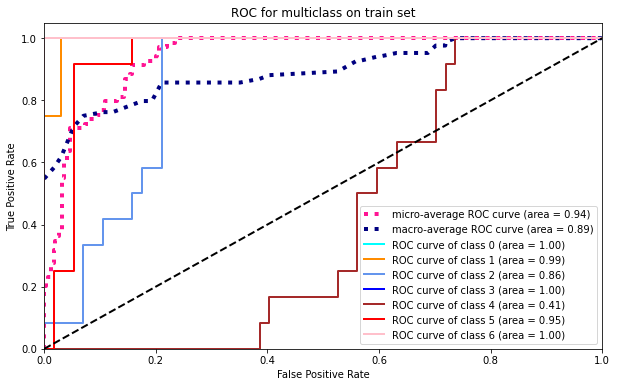

In [91]:
# Plot all ROC curves
plt.figure()
plt.figure(figsize=(10, 6))
plt.plot(fpr["micro"], tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,)

plt.plot(fpr["macro"],tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "blue", "brown", "red", "pink"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),)

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for multiclass on train set")
plt.legend(loc="lower right")
plt.show()

In [92]:
#test set

#model score on test set
Multimodel_score_test = Multimodel.score(test_Xm1_norm, test_Ym1)


multi_y_predict_test = Multimodel.predict(test_Xm1_norm)
multi_y_score_test = Multimodel.decision_function(test_Xm1_norm)

conf_matrix_test = confusion_matrix(test_Ym1, multi_y_predict_test)
conf_matrix_test

array([[2, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 1, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 3]])

In [93]:
#binarize test data

test_Ym1bin = label_binarize(test_Ym1, classes=activ_dirs )
multi_y_predict_testbin = label_binarize(multi_y_predict_test, classes=activ_dirs )
n_classest = test_Ym1bin.shape[1]

fprt = dict()
tprt = dict()
roc_auct = dict()
for i in range(n_classest):
    fprt[i], tprt[i], _ = roc_curve(test_Ym1bin[:, i], multi_y_score_test[:, i])
    roc_auct[i] = auc(fprt[i], tprt[i])
    
# Compute micro-average ROC curve and ROC area
fprt["micro"], tprt["micro"], _ = roc_curve(test_Ym1bin.ravel(), multi_y_score_test.ravel())
roc_auct["micro"] = auc(fprt["micro"], tprt["micro"])

In [94]:
# First aggregate all false positive rates
all_fprt = np.unique(np.concatenate([fprt[i] for i in range(n_classest)]))

# Then interpolate all ROC curves at this points
mean_tprt = np.zeros_like(all_fprt)
for i in range(n_classest):
    mean_tprt += np.interp(all_fprt, fprt[i], tprt[i])

# Finally average it and compute AUC
mean_tprt /= n_classest

fprt["macro"] = all_fprt
tprt["macro"] = mean_tprt
roc_auct["macro"] = auc(fprt["macro"], tprt["macro"])


<Figure size 432x288 with 0 Axes>

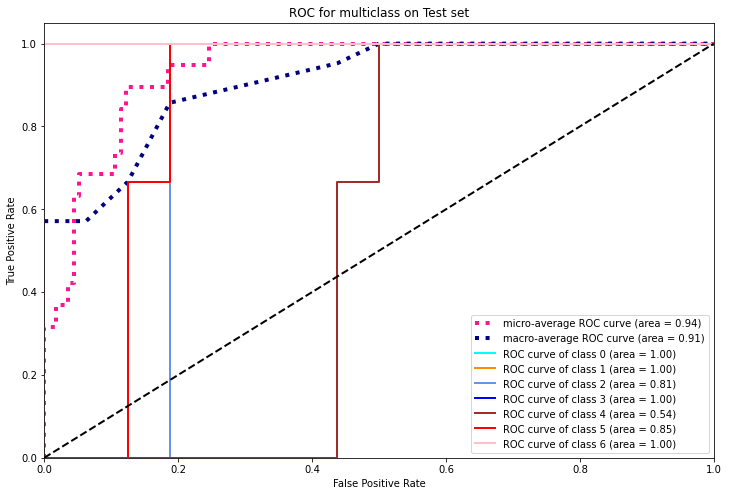

In [95]:
# Plot all ROC curves
plt.figure()
plt.figure(figsize=(12, 8))
plt.plot(fprt["micro"], tprt["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auct["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,)

plt.plot(fprt["macro"],tprt["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auct["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "blue", "brown", "red", "pink"])
for i, color in zip(range(n_classest), colors):
    plt.plot(fprt[i], tprt[i], color=color, lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auct[i]),)

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for multiclass on Test set")
plt.legend(loc="lower right")
plt.show()

In [96]:
#test error for best (l,C)

test_err = 1- Multimodel_score_test
print("multiclass test score: ", Multimodel_score_test)
print("multiclass test error: ", test_err)


multiclass test score:  0.9473684210526315
multiclass test error:  0.052631578947368474


As shown above, the matrix for train and test set including 7 classes, and fpr and tpr are also dictionaries contain 7 classes. When plot, we can plot each class with different colors and show the different under curve areas.

**Naive Bayes' classifier. Use both Gaussian and Multinomial
priors and compare the results.**

In [97]:
gnb_test_score = []
for l in L:
    train_instance_gau,test_instance_gau = split_multinomial(l)
    
    split_num = 1
    cols=[]
    for c in range(len(train_instance_gau.columns)):
        
        col = train_instance_gau.columns[c]
        col1 = col +'_'+ str(split_num)
        split_num +=1
        cols.append(col1)
    train_instance_gau.columns = cols
    test_instance_gau.columns = cols
    #print(cols)

    train_Xg = train_instance_gau.iloc[:, :-1]
    train_Yg = train_instance_gau.iloc[:, -1:]
    train_Yg = train_Yg.values.ravel()
    #print(train_Xg)
    #print(train_Yg)
    
    test_Xg = test_instance_gau.iloc[:, :-1]
    test_Yg = test_instance_gau.iloc[:, -1:]
    test_Yg = test_Yg.values.ravel()
    
    
    #perform Gaussian Naive Bayes
    gnb = GaussianNB()
    gnb = gnb.fit(train_Xg, train_Yg)
    test_score = gnb.score(test_Xg, test_Yg)
    gnb_test_score.append(test_score)

In [98]:
#gnb test errors

gnb_test_err = []
for s in gnb_test_score:
    error = 1-s
    gnb_test_err.append(error)
gnb_test_err

[0.052631578947368474,
 0.21052631578947367,
 0.1578947368421053,
 0.10526315789473684,
 0.10526315789473684,
 0.21052631578947367,
 0.21052631578947367,
 0.21052631578947367,
 0.3157894736842105,
 0.21052631578947367,
 0.26315789473684215,
 0.21052631578947367,
 0.21052631578947367,
 0.21052631578947367,
 0.1578947368421053,
 0.1578947368421053,
 0.21052631578947367,
 0.26315789473684215,
 0.21052631578947367,
 0.21052631578947367]

In [99]:
gnb_df= pd.DataFrame()
gnb_df['L'] = L
gnb_df['gnb_test_error'] = gnb_test_err
gnb_df['gnb_test_score'] = gnb_test_score
gnb_df

,L,gnb_test_error,gnb_test_score
0,1,0.052632,0.947368
1,2,0.210526,0.789474
2,3,0.157895,0.842105
3,4,0.105263,0.894737
4,5,0.105263,0.894737
5,6,0.210526,0.789474
6,7,0.210526,0.789474
7,8,0.210526,0.789474
8,9,0.315789,0.684211
9,10,0.210526,0.789474


In [100]:
max_gnbscore = gnb_df['gnb_test_score'].max()
min_gnberr = gnb_df['gnb_test_error'].min()
print("max gnb score: ", max_gnbscore)
print("min gnb error: ", min_gnberr)
gnbbest_l = gnb_df.loc[gnb_df['gnb_test_error']==min_gnberr, 'L'].min()
print("gnb best L: ", gnbbest_l)

max gnb score:  0.9473684210526315
min gnb error:  0.052631578947368474
gnb best L:  1


The best l=1 for Gaussian Naive Bayes classification

In [101]:
train_instance_gau1,test_instance_gau1 = split_multinomial(gnbbest_l)
    
train_Xgnb1 = train_instance_gau1.iloc[:, :-1]
train_Ygnb1 = train_instance_gau1.iloc[:, -1:]
train_Ygnb1 = train_Ygnb1.values.ravel()

test_Xgnb1 = test_instance_gau1.iloc[:, :-1]
test_Ygnb1 = test_instance_gau1.iloc[:, -1:]
test_Ygnb1 = test_Ygnb1.values.ravel()


#perform Gaussian Naive Bayes
gnb1 = GaussianNB().fit(train_Xgnb1, train_Ygnb1)

test_scoregnb1 = gnb1.score(test_Xgnb1, test_Ygnb1)
print(test_scoregnb1)

0.9473684210526315


In [102]:
#test gnb model on test set 
gnb1_y_predict_test = gnb1.predict(test_Xgnb1)
gnb1_y_score_test = gnb1.predict_log_proba(test_Xgnb1)

gnb1conf_matrix = confusion_matrix(test_Ygnb1, gnb1_y_predict_test)
print("confusion_matrix: ", gnb1conf_matrix)


confusion_matrix:  [[2 0 0 0 0 0 0]
 [0 1 0 0 1 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


In [103]:
#binarize test data

test_Ygnb1 = label_binarize(test_Ygnb1, classes=activ_dirs )
gnb1_y_predict_test = label_binarize(gnb1_y_predict_test, classes=activ_dirs )
n_classes_gnb1 = test_Ygnb1.shape[1]

fprgnb1 = dict()
tprgnb1 = dict()
roc_aucgnb1 = dict()
for i in range(n_classes_gnb1):
    fprgnb1[i], tprgnb1[i], _ = roc_curve(test_Ygnb1[:, i], gnb1_y_score_test[:, i])
    roc_aucgnb1[i] = auc(fprgnb1[i], tprgnb1[i])
    
# Compute micro-average ROC curve and ROC area
fprgnb1["micro"], tprgnb1["micro"], _ = roc_curve(test_Ygnb1.ravel(), gnb1_y_score_test.ravel())
roc_aucgnb1["micro"] = auc(fprgnb1["micro"], tprgnb1["micro"])

In [104]:
# First aggregate all false positive rates
all_fprgnb1 = np.unique(np.concatenate([fprgnb1[i] for i in range(n_classes_gnb1)]))

# Then interpolate all ROC curves at this points
mean_tprgnb1 = np.zeros_like(all_fprgnb1)
for i in range(n_classes_gnb1):
    mean_tprgnb1 += np.interp(all_fprgnb1, fprgnb1[i], tprgnb1[i])

# Finally average it and compute AUC
mean_tprgnb1 /= n_classes_gnb1

fprgnb1["macro"] = all_fprgnb1
tprgnb1["macro"] = mean_tprgnb1
roc_aucgnb1["macro"] = auc(fprgnb1["macro"], tprgnb1["macro"])


<Figure size 432x288 with 0 Axes>

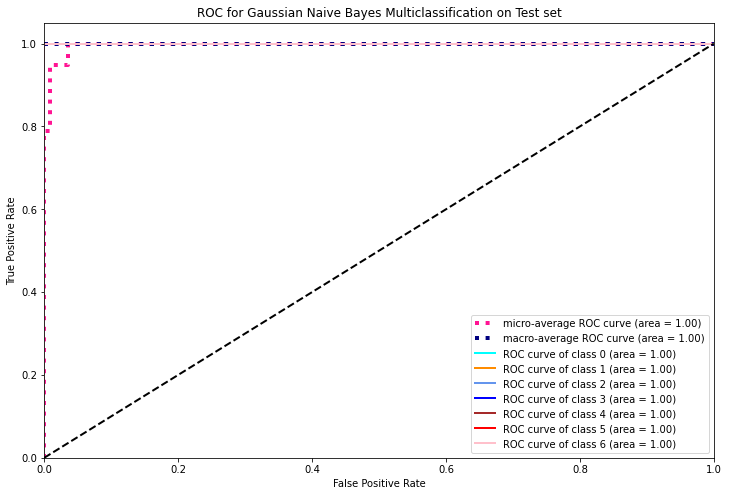

In [105]:
# Plot all ROC curves
plt.figure()
plt.figure(figsize=(12, 8))
plt.plot(fprgnb1["micro"], tprgnb1["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_aucgnb1["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,)

plt.plot(fprgnb1["macro"],tprgnb1["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_aucgnb1["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "blue", "brown", "red", "pink"])
for i, color in zip(range(n_classes_gnb1), colors):
    plt.plot(fprgnb1[i], tprgnb1[i], color=color, lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_aucgnb1[i]),)

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for Gaussian Naive Bayes Multiclassification on Test set")
plt.legend(loc="lower right")
plt.show()

**Multinomial MultinomialNB**

In [106]:
mnb_test_score = []
for l in L:
    train_instance_mnb,test_instance_mnb = split_multinomial(l)
    
    split_num = 1
    cols=[]
    for c in range(len(train_instance_mnb.columns)):
        
        col = train_instance_mnb.columns[c]
        col1 = col +'_'+ str(split_num)
        split_num +=1
        cols.append(col1)
    train_instance_mnb.columns = cols
    test_instance_mnb.columns = cols
    #print(cols)

    train_Xmnb = train_instance_mnb.iloc[:, :-1]
    train_Ymnb = train_instance_mnb.iloc[:, -1:]
    train_Ymnb = train_Ymnb.values.ravel()
    
    
    test_Xmnb = test_instance_mnb.iloc[:, :-1]
    test_Ymnb = test_instance_mnb.iloc[:, -1:]
    test_Ymnb = test_Ymnb.values.ravel()
    
    
    #perform multinomial Naive Bayes
    mnb = MultinomialNB().fit(train_Xmnb, train_Ymnb)
    
    test_score = mnb.score(test_Xmnb, test_Ymnb)
    mnb_test_score.append(test_score)

In [107]:
#mnb test errors

mnb_test_err = []
for s in mnb_test_score:
    error = 1-s
    mnb_test_err.append(error)
mnb_test_err

[0.0,
 0.052631578947368474,
 0.052631578947368474,
 0.052631578947368474,
 0.052631578947368474,
 0.1578947368421053,
 0.10526315789473684,
 0.10526315789473684,
 0.10526315789473684,
 0.10526315789473684,
 0.10526315789473684,
 0.10526315789473684,
 0.10526315789473684,
 0.1578947368421053,
 0.10526315789473684,
 0.10526315789473684,
 0.10526315789473684,
 0.1578947368421053,
 0.10526315789473684,
 0.1578947368421053]

In [108]:
mnb_df= pd.DataFrame()
mnb_df['L'] = L
mnb_df['mnb_test_error'] = mnb_test_err
mnb_df['mnb_test_score'] = mnb_test_score
mnb_df


,L,mnb_test_error,mnb_test_score
0,1,0.000000,1.000000
1,2,0.052632,0.947368
2,3,0.052632,0.947368
3,4,0.052632,0.947368
4,5,0.052632,0.947368
5,6,0.157895,0.842105
6,7,0.105263,0.894737
7,8,0.105263,0.894737
8,9,0.105263,0.894737
9,10,0.105263,0.894737


In [109]:
max_mnbscore = mnb_df['mnb_test_score'].max()
min_mnberr = mnb_df['mnb_test_error'].min()
print("mnb max score: ", max_mnbscore)
print("mnb min error: ", min_mnberr)
mnbbest_l = mnb_df.loc[mnb_df['mnb_test_error']==min_mnberr, 'L'].min()
print("mnb best L: ", mnbbest_l)

mnb max score:  1.0
mnb min error:  0.0
mnb best L:  1


So the best l for multinomial Naive Bayes is 1

In [110]:
train_instance_mnb1,test_instance_mnb1 = split_multinomial(mnbbest_l)
    
train_Xmnb1 = train_instance_mnb1.iloc[:, :-1]
train_Ymnb1 = train_instance_mnb1.iloc[:, -1:]
train_Ymnb1 = train_Ymnb1.values.ravel()


test_Xmnb1 = test_instance_mnb1.iloc[:, :-1]
test_Ymnb1 = test_instance_mnb1.iloc[:, -1:]
test_Ymnb1 = test_Ymnb1.values.ravel()


#perform multinomial Naive Bayes
mnb1 = MultinomialNB().fit(train_Xmnb1, train_Ymnb1)

mnbtest_score1 = mnb1.score(test_Xmnb1, test_Ymnb1)
mnbtest_score1

1.0

In [111]:
#test gnb model on test set 
mnb1_y_predict_test = mnb1.predict(test_Xmnb1)
mnb1_y_score_test = mnb1.predict_log_proba(test_Xmnb1)

mnb1conf_matrix = confusion_matrix(test_Ymnb1, mnb1_y_predict_test)
print("confusion_matrix: ", mnb1conf_matrix)


confusion_matrix:  [[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


<Figure size 432x288 with 0 Axes>

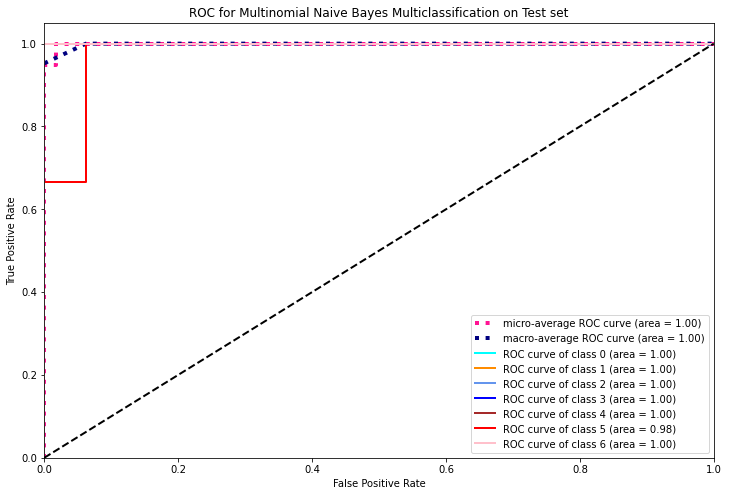

In [112]:
#binarize test data

test_Ymnb1 = label_binarize(test_Ymnb1, classes=activ_dirs )
mnb1_y_predict_test = label_binarize(mnb1_y_predict_test, classes=activ_dirs )
n_classes_mnb1 = test_Ymnb1.shape[1]

fprmnb1 = dict()
tprmnb1 = dict()
roc_aucmnb1 = dict()
for i in range(n_classes_mnb1):
    fprmnb1[i], tprmnb1[i], _ = roc_curve(test_Ymnb1[:, i], mnb1_y_score_test[:, i])
    roc_aucmnb1[i] = auc(fprmnb1[i], tprmnb1[i])
    
# Compute micro-average ROC curve and ROC area
fprmnb1["micro"], tprmnb1["micro"], _ = roc_curve(test_Ymnb1.ravel(), mnb1_y_score_test.ravel())
roc_aucmnb1["micro"] = auc(fprmnb1["micro"], tprmnb1["micro"])

# First aggregate all false positive rates
all_fprmnb1 = np.unique(np.concatenate([fprmnb1[i] for i in range(n_classes_mnb1)]))

# Then interpolate all ROC curves at this points
mean_tprmnb1 = np.zeros_like(all_fprmnb1)
for i in range(n_classes_mnb1):
    mean_tprmnb1 += np.interp(all_fprmnb1, fprmnb1[i], tprmnb1[i])

# Finally average it and compute AUC
mean_tprmnb1 /= n_classes_mnb1

fprmnb1["macro"] = all_fprmnb1
tprmnb1["macro"] = mean_tprmnb1
roc_aucmnb1["macro"] = auc(fprmnb1["macro"], tprmnb1["macro"])


# Plot all ROC curves
plt.figure()
plt.figure(figsize=(12, 8))
plt.plot(fprmnb1["micro"], tprmnb1["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_aucmnb1["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,)

plt.plot(fprmnb1["macro"],tprmnb1["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_aucmnb1["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "blue", "brown", "red", "pink"])
for i, color in zip(range(n_classes_mnb1), colors):
    plt.plot(fprmnb1[i], tprmnb1[i], color=color, lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_aucmnb1[i]),)

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for Multinomial Naive Bayes Multiclassification on Test set")
plt.legend(loc="lower right")
plt.show()


In [113]:
#compare test scores and errors for the 3 types of models
print("multiclass test score: ", Multimodel_score_test)
print("multiclass test error: ", test_err)
print("GNB max model score: ", max_gnbscore)
print("GNB min model error: ", min_gnberr)
print("MultiNB max model score: ", max_mnbscore)
print("MultiNB min model error: ", min_mnberr)

multiclass test score:  0.9473684210526315
multiclass test error:  0.052631578947368474
GNB max model score:  0.9473684210526315
GNB min model error:  0.052631578947368474
MultiNB max model score:  1.0
MultiNB min model error:  0.0


Based on the test score and test errors, multinomial Naive Bayes classification that gets lower test error, 0, performs better than the other two methods for multiclssification. 